# **Predicting Mental Health Treatment-Seeking Behavior Using Machine Learning**

This project aims to predict whether an individual is likely to seek treatment for mental health concerns using workplace survey data. The task is framed as a **binary classification** problem, with the target variable indicating treatment (Yes/No).

The dataset comes from the OSMI Mental Health in Tech Survey, which collects demographic and other information about employees’ experiences with mental health.

The dataset exploratory analysis is done in another notebook which is also submitted in github.

The workflow follows a structured machine learning pipeline:

1. Data Preprocessing – standardisation, imputation, and encoding.
2. Model Training & Optimisation – Logistic Regression, Random Forest, and Neural Network with hyperparameter tuning.
3. Model Training & Optimisation – Logistic Regression, Random Forest, and Neural Network with hyperparameter tuning.
4. Model Comparison  – evaluating accuracy, F1, ROC-AUC, Average Precision, and calibration.
5. Feature Reduction  – testing whether a reduced set of the 15 most important features preserves predictive performance.
6. Error & Fairness Analysis – examining subgroup-level misclassifications to identify blind spots in prediction.


In [1]:
#Access dataset from google colab
#The dataset link and dataset is provided in Github

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/survey.csv")


#explore the dataset
df.shape
df.columns.tolist()
df.head()

Mounted at /content/drive


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


### Checking Data Structure

Prior to preprocessing, the dataset was examined to better understand its composition.  
- The **number of unique values** in each column was inspected to distinguish between categorical and numeric features and to highlight variables with inconsistent or messy categories.  
- The **percentage of missing values** in each column was also calculated in order to assess overall data quality and inform imputation strategies.

In [2]:
#Unique values in each column - for better understanding
print(" Unique values in each column:\n")
for column in df.columns:
    unique_vals = df[column].unique()
    print(f"Column '{column}' has {len(unique_vals)} unique value(s): {unique_vals[:10]}")
    if len(unique_vals) > 10:
        print("  ... and so on..\n")



#Percentage of missing values
print("\n Percentage of missing values in each column:\n")
missing_percent = df.isnull().mean() * 100
print(missing_percent[missing_percent > 0].round(2))


 Unique values in each column:

Column 'Timestamp' has 1246 unique value(s): ['2014-08-27 11:29:31' '2014-08-27 11:29:37' '2014-08-27 11:29:44'
 '2014-08-27 11:29:46' '2014-08-27 11:30:22' '2014-08-27 11:31:22'
 '2014-08-27 11:31:50' '2014-08-27 11:32:05' '2014-08-27 11:32:39'
 '2014-08-27 11:32:43']
  ... and so on..

Column 'Age' has 53 unique value(s): [37 44 32 31 33 35 39 42 23 29]
  ... and so on..

Column 'Gender' has 49 unique value(s): ['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female']
  ... and so on..

Column 'Country' has 48 unique value(s): ['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia']
  ... and so on..

Column 'state' has 46 unique value(s): ['IL' 'IN' nan 'TX' 'TN' 'MI' 'OH' 'CA' 'CT' 'MD']
  ... and so on..

Column 'self_employed' has 3 unique value(s): [nan 'Yes' 'No']
Column 'family_history' has 2 unique value(s): ['No' 'Yes']
Column 'treatment' has 2 

Since the Gender column contains nearly 49 distinct entries representing variations of male and female, it is important to display all unique values in order to guide effective preprocessing and standardisation


In [3]:
print(df["Gender"].unique())

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']


In [4]:
#Import all neccessary modules
import sys, os, re, json, math
import numpy as np, pandas as pd
from pathlib import Path
from IPython.display import display
import tensorflow as tf

#Ensure reproducibility
RANDOM_STATE = 21


np.random.seed(RANDOM_STATE)
tf.random.set_seed(21)

### Setting Up Results Directories  

To ensure that all outputs are well organised and reproducible, dedicated directories were created for storing tables, figures, and trained models.  
- The base directory is defined as `results/`.  
- Subdirectories are automatically generated for `tables/`, `figures/`, and `models/`.  
- This structure allows results to be systematically saved and referenced later in the report.  


In [5]:
# Define the base directory for all result outputs (e.g., tables, figures, models)
BASE = Path("results")

# Create a dictionary of subdirectories under the base directory
DIRS = {"tables": BASE/"tables", "figures": BASE/"figures", "models": BASE/"models"}
for d in DIRS.values(): d.mkdir(parents=True, exist_ok=True)


print("DATA_PATH:", df)
print("Results folders:", {k: str(v) for k, v in DIRS.items()})

DATA_PATH:                 Timestamp  Age  Gender         Country state self_employed  \
0     2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1     2014-08-27 11:29:37   44       M   United States    IN           NaN   
2     2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3     2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4     2014-08-27 11:30:22   31    Male   United States    TX           NaN   
...                   ...  ...     ...             ...   ...           ...   
1254  2015-09-12 11:17:21   26    male  United Kingdom   NaN            No   
1255  2015-09-26 01:07:35   32    Male   United States    IL            No   
1256  2015-11-07 12:36:58   34    male   United States    CA            No   
1257  2015-11-30 21:25:06   46       f   United States    NC            No   
1258  2016-02-01 23:04:31   25    Male   United States    IL            No   

     family_history treatment work_interfere    no_e

### Data Cleaning and Preprocessing  

The raw dataset contains a mix of free-text, categorical, and numeric fields, with several inconsistencies and high-cardinality columns.  
To prepare the data for modeling, the following preprocessing steps were applied:

1. **Dropping Irrelevant Columns**  
   - Removed `comments`, `Timestamp`, `state`, and `Country`.  
   These were either metadata, highly sparse, or high-cardinality fields that would add noise without predictive value.

2. **Target Variable Construction**  
   - The column `treatment` (Yes/No) was mapped into a binary outcome:  
     - `Yes → 1` (treatment sought)  
     - `No → 0` (treatment not sought)  
   - Rows with missing target values were dropped.

3. **Gender Cleaning**  
   - Raw `Gender` responses contained 49 distinct strings (e.g., "Male", "M", "maile", "Trans-female").  
   - These were consolidated into three categories:  
     - `male`, `female`, `other`.  
   - If no gender column was found, all entries default to `other`.

4. **Age Cleaning and Bucketing**  
   - Converted `Age` to numeric, coerced invalid entries to NaN, and filtered to the plausible working range (16–60 years).  
   - Constructed two features:  
     - `age_clean` (continuous numeric).  
     - `age_bucket` (categorical bins: 10s, 20s, …, 70+).  
   - Out-of-range or missing ages were labeled as `unknown`.

5. **Work Interference Normalisation**  
   - Standardised responses in `work_interfere` to four levels:  
     - `never`, `rarely`, `sometimes`, `often`.  
   - Missing values were imputed stochastically from the empirical distribution to preserve variation.

6. **General Column Normalisation**  
   - Binary fields (`remote_work`, `benefits`, `self_employed`, `seek_help`, `family_history`, `tech_company`, `supervisor`)  
     → mapped to `yes`, `no`, `unknown`.  
   - Ternary fields with ambiguous responses (`care_options`, `wellness_program`, `mental_health_interview`, `phys_health_interview`, `mental_vs_physical`, `obs_consequence`)  
     → mapped to `yes`, `no`, `unsure`, `unknown`.

7. **Company Size Bucketing**  
   - Standardised `no_employees` into consistent ranges:  
     - `1–5`, `6–25`, `26–100`, `100–500`, `500–1000`, `1000+`.  
   - Missing or ambiguous entries were labeled as `unknown`.

8. **Data Type Enforcement**  
   - All string/object columns were cast to categorical.  
   - Ensured `age_clean` exists and is numeric.  

9. **Rare Category Grouping**  
   - Categories with frequency <1% were collapsed into an `other` label, except where already labeled `unknown`.

10. **Final Dataset**  
    - Features `X`: cleaned feature matrix (mixed categorical and numeric).  
    - Target `y`: binary treatment outcome.  

**Cleaning Summary Outputs**  
- Total rows after cleaning.  
- Number of numeric and categorical features.  
- Distribution of the target variable.  
- Preview of the cleaned dataset (`X.head(10)`).  


In [6]:
def find_col(cols, name_like, exact=False):
    low = {c.lower(): c for c in cols}
    if exact:
        return low.get(name_like.lower(), None)
    needle = name_like.lower()
    for c in cols:
        if needle in c.lower():
            return c
    return None

def bucket_age(s: pd.Series) -> pd.DataFrame:
    age_num = pd.to_numeric(s, errors="coerce")
    age_clean = age_num.where((age_num >= 16) & (age_num <= 60))
    bins   = [10,19,29,39,49,59,69,120]
    labels = ["10s","20s","30s","40s","50s","60s","70+"]
    age_bucket = pd.cut(age_clean, bins=bins, labels=labels, include_lowest=True)
    age_bucket = age_bucket.cat.add_categories("unknown").fillna("unknown")
    return pd.DataFrame({"age": age_num, "age_clean": age_clean, "age_bucket": age_bucket})

def normalize_yes_no_unknown(v: str) -> str:
    x = str(v).strip().lower()
    if x in {"yes","y","1","true"}:  return "yes"
    if x in {"no","n","0","false"}:  return "no"
    if "don't know" in x or "dont know" in x or "not sure" in x: return "unknown"
    if x in {"", "nan"}: return "unknown"
    return x

def normalize_yes_no_unsure_unknown(v: str) -> str:
    x = str(v).strip().lower()
    if x in {"yes","y","1","true"}:  return "yes"
    if x in {"no","n","0","false"}:  return "no"
    if "maybe" in x:                return "unsure"
    if "don't know" in x or "dont know" in x or "not sure" in x or x in {"","nan"}:
        return "unknown"
    return x

def normalize_company_size(v: str) -> str:
    x = str(v).strip().lower().replace("–","-").replace("—","-").replace("to","-")
    if "1-5" in x:        return "1–5"
    if "6-25" in x:       return "6–25"
    if "26-100" in x:     return "26–100"
    if "100-500" in x:    return "100–500"
    if "500-1000" in x:   return "500–1000"
    if "more than 1000" in x or "1000+" in x or x == "1000" or " 1000" in x:
        return "1000+"
    return "unknown"

def impute_categorical_by_distribution(series: pd.Series, allowed_levels, random_state = RANDOM_STATE ):

    s = series.copy()
    s = s.where(s.isin(allowed_levels), np.nan)

    vc = s.value_counts(normalize=True, dropna=True).reindex(allowed_levels).fillna(0.0)
    total = vc.sum()
    if total == 0:
        vc[:] = 1.0 / len(allowed_levels)
    else:
        vc = vc / total

    probs  = vc.values
    levels = vc.index.tolist()

    rng = np.random.default_rng(random_state)
    miss = s.isna()
    if miss.any():
        s.loc[miss] = rng.choice(levels, size=int(miss.sum()), p=probs)

    return s.astype("category")

def group_rare_categories(df_in: pd.DataFrame, cols, min_freq=0.01, other_label="other"):
    df = df_in.copy()
    n = len(df)
    if n == 0:
        return df
    for c in cols:
        if c not in df.columns:
            continue
        ser = df[c].astype("category")
        freq = ser.value_counts(dropna=True) / n
        rare = set(freq[freq < min_freq].index)
        rare = {x for x in rare if str(x).lower() not in {"unknown","other"}}
        if rare:
            df[c] = ser.apply(lambda x: other_label if x in rare else x).astype("category")
    return df

def norm_col(df_in, src_name_like, fn, dst_name=None):

    csrc = find_col(df_in.columns, src_name_like, exact=True) or find_col(df_in.columns, src_name_like)
    dst  = dst_name if dst_name else (csrc if csrc else src_name_like)

    ser = df_in[csrc] if csrc else pd.Series(["unknown"] * len(df_in), index=df_in.index)
    df_in[dst] = ser.map(fn).astype("category")
    if csrc and csrc != dst:
        df_in.drop(columns=[csrc], inplace=True)


print("Raw shape:", df.shape)

# Drop irrelevant columns
to_drop = []
for name in ["comments","Timestamp","state","Country"]:
    c = find_col(df.columns, name)
    if c: to_drop.append(c)
print("Dropping columns:", to_drop)
df1 = df.drop(columns=to_drop, errors="ignore").copy()

# Target column
t_col = find_col(df1.columns, "treatment", exact=True) or find_col(df1.columns, "treatment")
assert t_col is not None, "Target column 'treatment' not found."
y = df1[t_col].map({"Yes": 1, "No": 0})
keep = ~y.isna()
df1  = df1.loc[keep].copy()
y    = y.loc[keep].astype(int)

print("\n=== Target balance ===")
print(y.value_counts())
print(f"Positive rate: {y.mean():.3f}")

# clean gender column
male_like = {
    "male","m","man","cis male","msle","mail","make","maile","mal","malr",
    "male-ish","male (cis)","cis man","guy (-ish) ^_^",
    "ostensibly male, unsure what that really means"
}
female_like = {
    "female","f","woman","cis female","femail","femake","female (trans)",
    "female (cis)","cis-female/femme","trans woman","trans-female"
}
male_like_lower   = {x.lower() for x in male_like}
female_like_lower = {x.lower() for x in female_like}

g_src = find_col(df1.columns, "gender", exact=True) or find_col(df1.columns, "gender")
if g_src is None:
    df1["gender_cleaned"] = pd.Series(["other"] * len(df1), index=df1.index, dtype="category")
else:
    def _clean_gender(v) -> str:
        if pd.isna(v): return "other"
        vv = str(v).strip().lower()
        if vv in male_like_lower:   return "male"
        if vv in female_like_lower: return "female"
        return "other"
    df1["gender_cleaned"] = df1[g_src].apply(_clean_gender).astype("category")
    if g_src != "gender_cleaned":
        df1.drop(columns=[g_src], inplace=True)

# clean and organise age column
a_src = find_col(df1.columns, "age", exact=True) or find_col(df1.columns, "age")
if a_src is None:
    df_age = pd.DataFrame({"age": np.nan, "age_clean": np.nan, "age_bucket": "unknown"}, index=df1.index)
else:
    df_age = bucket_age(df1[a_src])
df1["age"]        = df_age["age"]
df1["age_clean"]  = df_age["age_clean"]
df1["age_bucket"] = df_age["age_bucket"]
for raw_age_col in ["Age", "age"]:
    if raw_age_col in df1.columns:
        df1.drop(columns=[raw_age_col], inplace=True)

#normalize and impute to allowed levels
wi_src = find_col(df1.columns, "work_interfere", exact=True) or find_col(df1.columns, "work_interfere")
allowed_wi = ["never","rarely","sometimes","often"]
if wi_src is None:
    df1["work_interfere"] = pd.Series(["unknown"] * len(df1), index=df1.index, dtype="category")
else:
    wi = df1[wi_src].astype(str).str.strip().str.lower()
    wi = wi.where(wi.isin(allowed_wi), np.nan)  # keep only allowed; others → NaN
    wi = impute_categorical_by_distribution(wi, allowed_levels=allowed_wi, random_state=RANDOM_STATE)
    df1["work_interfere"] = wi
    if wi_src != "work_interfere":
        df1.drop(columns=[wi_src], inplace=True)

# Normalize remaining fields
for col_like in [
    "remote_work","benefits","self_employed","seek_help",
    "family_history","tech_company","supervisor"
]:
    norm_col(df1, col_like, normalize_yes_no_unknown)

for col_like in [
    "care_options","wellness_program",
    "mental_health_interview","phys_health_interview",
    "mental_vs_physical","obs_consequence"
]:
    norm_col(df1, col_like, normalize_yes_no_unsure_unknown)

#bucket Company size
emp_src = find_col(df1.columns, "no_employees", exact=True) or find_col(df1.columns, "no_employees")
if emp_src:
    df1["no_employees_bucket"] = df1[emp_src].apply(normalize_company_size).astype("category")
    if emp_src != "no_employees_bucket":
        df1.drop(columns=[emp_src], inplace=True)
else:
    df1["no_employees_bucket"] = pd.Series(["unknown"] * len(df1), index=df1.index, dtype="category")

# build X and enforce dtypes
X = df1.drop(columns=[t_col], errors="ignore").copy()

# Convert remaining object to category
for c in X.columns:
    if pd.api.types.is_object_dtype(X[c]):
        X[c] = X[c].astype("category")

# Ensure age_clean as numeric exists
if "age_clean" not in X.columns:
    X["age_clean"] = pd.Series(np.nan, index=X.index)
X["age_clean"] = pd.to_numeric(X["age_clean"], errors="coerce")

numeric_cols     = ["age_clean"]
categorical_cols = [c for c in X.columns if c not in numeric_cols and c.lower() not in {"age"}]

# Rare-category grouping at 1%
X = group_rare_categories(X, categorical_cols, min_freq=0.01, other_label="other")

# summary
print("\n=== Cleaning Summary ===")
print("Rows after cleaning:", len(X))
print("Columns after cleaning:", X.shape[1])
print("Numeric columns:", numeric_cols)
print("Categorical columns (count):", len(categorical_cols))
print("\nTarget counts:\n", y.value_counts())
print(f"Positive rate: {y.mean():.3f}")

print("\n=== X.head(10) ===")
display(X.head(10))

Raw shape: (1259, 27)
Dropping columns: ['comments', 'Timestamp', 'state', 'Country']

=== Target balance ===
treatment
1    637
0    622
Name: count, dtype: int64
Positive rate: 0.506

=== Cleaning Summary ===
Rows after cleaning: 1259
Columns after cleaning: 23
Numeric columns: ['age_clean']
Categorical columns (count): 22

Target counts:
 treatment
1    637
0    622
Name: count, dtype: int64
Positive rate: 0.506

=== X.head(10) ===


,self_employed,family_history,work_interfere,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,...,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,gender_cleaned,age_clean,age_bucket,no_employees_bucket
0,unknown,no,often,no,yes,yes,unknown,no,yes,Yes,...,Some of them,yes,no,unsure,yes,no,female,37.0,30s,6–25
1,unknown,no,rarely,no,no,unknown,no,unknown,unknown,Don't know,...,No,no,no,no,unknown,no,male,44.0,40s,1000+
2,unknown,no,rarely,no,yes,no,no,no,no,Don't know,...,Yes,yes,yes,yes,no,no,male,32.0,30s,6–25
3,unknown,yes,often,no,yes,no,yes,no,no,No,...,Some of them,no,unsure,unsure,no,yes,male,31.0,30s,26–100
4,unknown,no,never,yes,yes,yes,no,unknown,unknown,Don't know,...,Some of them,yes,yes,yes,unknown,no,male,31.0,30s,100–500
5,unknown,yes,sometimes,no,yes,yes,unknown,no,unknown,Don't know,...,Yes,yes,no,unsure,unknown,no,male,33.0,30s,6–25
6,unknown,yes,sometimes,yes,yes,no,no,no,no,No,...,Some of them,no,no,no,unknown,no,female,35.0,30s,1–5
7,unknown,no,never,yes,yes,no,yes,no,no,Yes,...,No,no,no,no,no,no,male,39.0,30s,1–5
8,unknown,yes,sometimes,no,yes,yes,yes,no,no,No,...,Yes,yes,no,unsure,no,no,female,42.0,40s,100–500
9,unknown,no,never,no,yes,unknown,no,unknown,unknown,Don't know,...,Yes,yes,unsure,unsure,yes,no,male,23.0,20s,26–100


### Section 2 — Train/Test Split and Preprocessing Pipeline  

Following data cleaning, the dataset was partitioned and a preprocessing pipeline was created to ensure consistency and reproducibility across all models.  

1. **Train/Test Split**  
   - Performed a stratified split into 70% training and 30% testing sets, preserving the 50/50 class balance of the target.  
   - This ensures that both subsets maintain a representative distribution of treatment vs non-treatment outcomes.  
   - Resulting sizes:  
     - Training: ~70% of rows  
     - Testing: ~30% of rows  

2. **Primary Metric Selection**  
   - Based on class balance:  
     - If prevalence were outside the range 35–65%, **Average Precision** (AP) would be more appropriate.  
     - Since the target is ~50/50, the **F1 score** was chosen as the primary evaluation metric.  

3. **Feature Schema**  
   - From Section 1, only one numeric feature is present: `age_clean`.  
   - All other features (n=22) are categorical, cast explicitly to `category` dtype for efficiency and consistency.  
   - A schema of numeric vs categorical features was saved for audit purposes.  

4. **Column-wise Transformers**  
   - **Numeric pipeline**:  
     - Imputation: median strategy.  
     - Scaling: standardisation to zero mean and unit variance.  
   - **Categorical pipeline**:  
     - Imputation: most frequent category.  
     - Encoding: one-hot encoding with `handle_unknown="ignore"`.  

5. **ColumnTransformer Integration**  
   - Combined numeric and categorical pipelines using `ColumnTransformer`.  
   - Dropped any non-specified columns (`remainder="drop"`).  
   - Disabled verbose feature name prefixes for clarity in downstream interpretation.  

6. **Cross-Validation Strategy**  
   - Defined a **StratifiedKFold** object (5 splits, shuffled, fixed random state) to be reused across all model tuning.  
   - Stratification maintains consistent class balance within each fold.  

7. **Audit Export**  
   - Exported the feature schema (numeric vs categorical) into `results/tables/schema_section2.csv` for reporting and reproducibility.  

**Outcome:**  
- The dataset is now fully partitioned and preprocessed in a consistent, reusable form.  
- This `preprocess` object is directly applied within the modeling pipelines (e.g., Logistic Regression, Random Forest, Neural Network), ensuring that train, validation, and test data undergo identical transformations.  


In [7]:
# Split & Preprocessing Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np


# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print(f"Train positive rate: {y_train.mean():.3f} | Test positive rate: {y_test.mean():.3f}")


# Decide primary metric based on imbalance (threshold ≈ 35/65)
PRIMARY_METRIC = "average_precision" if (y_train.mean() < 0.35 or y_train.mean() > 0.65) else "f1"
print("Primary metric:", PRIMARY_METRIC)


#  Schema
# Only one numeric column: age_clean
numeric_cols = ["age_clean"]
categorical_cols = [c for c in X_train.columns if c not in numeric_cols and c.lower() != "age"]

# ensure types
X_train = X_train.copy()
X_test  = X_test.copy()
X_train["age_clean"] = pd.to_numeric(X_train["age_clean"], errors="coerce")
X_test["age_clean"]  = pd.to_numeric(X_test["age_clean"],  errors="coerce")
for c in categorical_cols:
    if str(X_train[c].dtype) != "category":
        X_train[c] = X_train[c].astype("category")
    if str(X_test[c].dtype) != "category":
        X_test[c] = X_test[c].astype("category")

print(f"[Schema] numeric = {numeric_cols} | categorical = {len(categorical_cols)} columns")



# Column-wise transformers
num_tf = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

cat_tf = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])



#  Preprocess object used by all models
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols),
        ("cat", cat_tf, categorical_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("[Preprocess] ready.")

# CV object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("[CV] StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)")


# save the schema for the report
schema_df = pd.DataFrame({
    "feature": numeric_cols + categorical_cols,
    "dtype":   (["numeric"] * len(numeric_cols)) + (["categorical"] * len(categorical_cols))
})
schema_path = DIRS["tables"] / "schema_section2.csv"
schema_df.to_csv(schema_path, index=False)
print("Saved schema ->", schema_path)



Train shape: (881, 23) | Test shape: (378, 23)
Train positive rate: 0.506 | Test positive rate: 0.505
Primary metric: f1
[Schema] numeric = ['age_clean'] | categorical = 22 columns
[Preprocess] ready.
[CV] StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
Saved schema -> results/tables/schema_section2.csv


### Model 1 — Logistic Regression  

Logistic Regression was chosen as a  first (baseline linear) model due to its interpretability and well-calibrated probability outputs. The following steps were carried out:  

1. **Pipeline Construction**  
   - Combined the preprocessing transformer with a `LogisticRegression` classifier.  
   - Configured `max_iter=2000` for convergence and fixed `random_state` for reproducibility.  

2. **Hyperparameter Search**  
   - Performed a **RandomizedSearchCV** (40 iterations, 5-fold stratified CV).  
   - Search space included:  
     - Regularisation strength `C` sampled log-uniformly between `1e-3` and `1e+2`.  
     - Penalty types: `l1` and `l2`.  
     - Solvers: `liblinear` and `saga`.  
   - The model was optimised against the primary metric (F1 score, chosen in Section 2).  
   - Best parameters and mean cross-validation score were reported.  

3. **Evaluation on Test Set (Default Threshold = 0.50)**  
   - Metrics computed:  
     - **ROC AUC** (discrimination ability).  
     - **Average Precision (AP)** (precision–recall trade-off).  
     - **F1**, **Precision**, **Recall** (classification balance).  
     - **Brier Score** (probability calibration).  
   - A **classification report** was produced to show class-level performance for "No Treatment" vs "Treatment".  

4. **Threshold Tuning**  
   - The default threshold of 0.50 was compared to thresholds chosen on the **training set**:  
     - `t_f1`: threshold that maximises F1.  
     - `t_rec`: threshold achieving at least 80% recall while maximising F1 among those points.  
   - Test performance was then re-evaluated at these thresholds.  
   - A summary table was produced comparing precision, recall, and F1 across scenarios.  

5. **Visualisations**  
   - **Confusion Matrices** at different thresholds (0.50, t_f1, t_rec) to illustrate trade-offs in FP/FN counts.  
   - **ROC Curve** to evaluate discrimination across all thresholds.  
   - **Precision–Recall Curve** to assess balance between recall and precision.  
   - **Calibration Curve** to examine how well predicted probabilities match observed outcomes.  



Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'clf__C': np.float64(0.38312693808612125), 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best CV score: 0.770

=== Logistic Regression — Test Metrics (thr=0.50) ===
roc_auc: 0.819
ap: 0.807
f1: 0.739
precision: 0.751
recall: 0.728
brier: 0.174

=== Classification Report (thr=0.50) ===
              precision    recall  f1-score   support

No Treatment       0.73      0.75      0.74       187
   Treatment       0.75      0.73      0.74       191

    accuracy                           0.74       378
   macro avg       0.74      0.74      0.74       378
weighted avg       0.74      0.74      0.74       378


[LR] Train-picked thresholds -> t_f1=0.502, t_rec@0.80=0.502

=== LR — Test metrics at thresholds (chosen on train) ===


,scenario,thr,f1,precision,recall
0,default_0.50,0.500000,0.739362,0.751351,0.727749
1,t_f1(train),0.502252,0.736000,0.750000,0.722513
2,t_rec(train),0.502252,0.736000,0.750000,0.722513


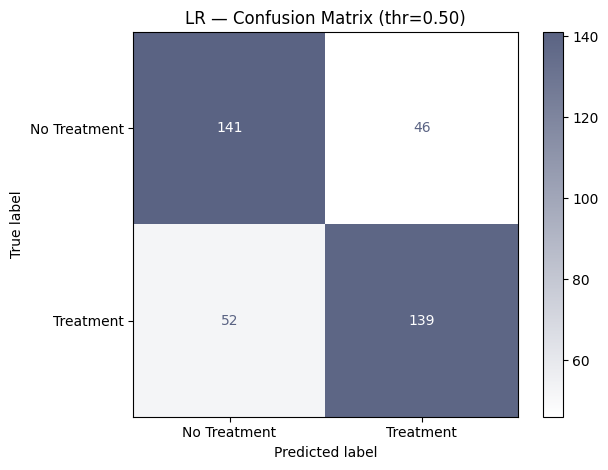

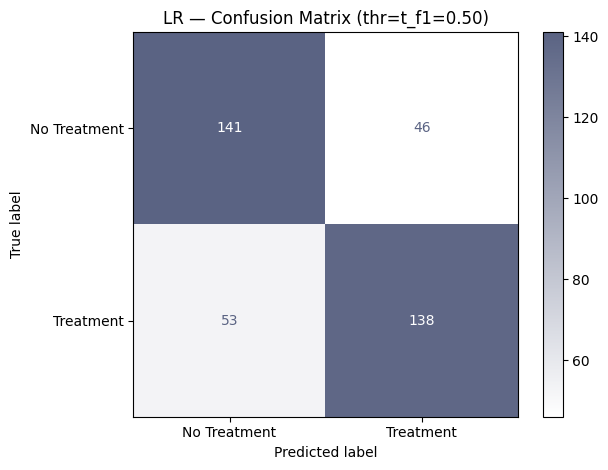

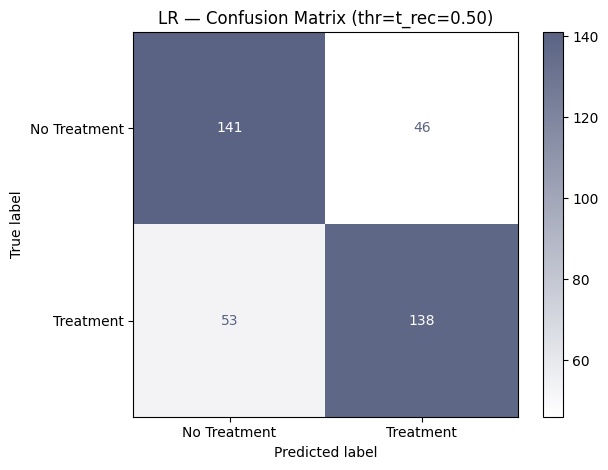

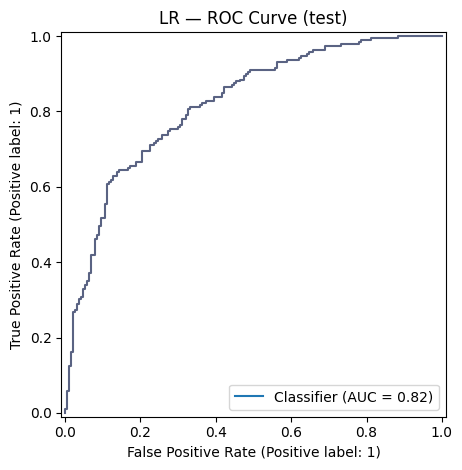

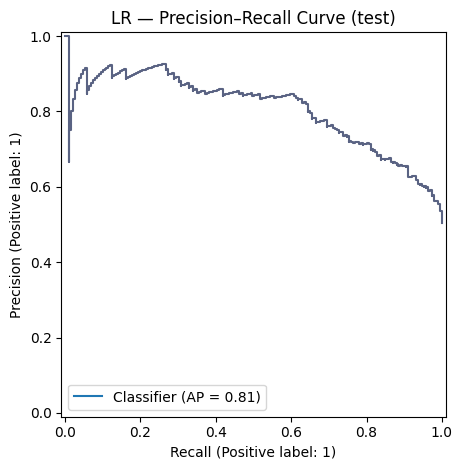

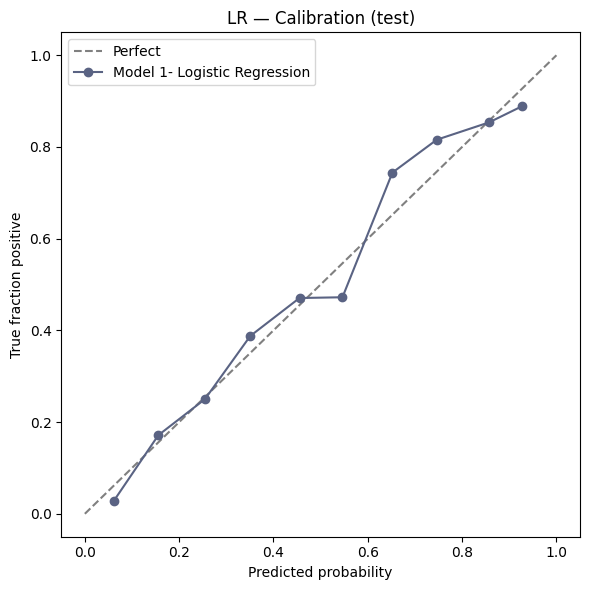

In [8]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, brier_score_loss,
    classification_report, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Build pipeline
logreg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

# Search space
param_dist = {
    "clf__C": loguniform(1e-3, 1e2),
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["liblinear", "saga"]  # support l1/l2
}

#Randomized search with CV
search_lr = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring=PRIMARY_METRIC,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
search_lr.fit(X_train, y_train)

print("Best params:", search_lr.best_params_)
print("Best CV score:", f"{search_lr.best_score_:.3f}")

best_lr = search_lr.best_estimator_

# Test set evaluation (thr=0.50)
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.50).astype(int)

metrics_lr = {
    "roc_auc": roc_auc_score(y_test, y_prob_lr),
    "ap": average_precision_score(y_test, y_prob_lr),
    "f1": f1_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr, zero_division=0),
    "recall": recall_score(y_test, y_pred_lr),
    "brier": brier_score_loss(y_test, y_prob_lr)
}

print("\n=== Logistic Regression — Test Metrics (thr=0.50) ===")
for k,v in metrics_lr.items():
    print(f"{k}: {v:.3f}")

print("\n=== Classification Report (thr=0.50) ===")
print(classification_report(y_test, y_pred_lr, target_names=["No Treatment","Treatment"]))

#  Threshold selection
from sklearn.metrics import precision_recall_curve

def choose_threshold_on_train(model, X_tr, y_tr, target_recall=0.80):
    y_prob_tr = model.predict_proba(X_tr)[:, 1]
    P, R, T = precision_recall_curve(y_tr, y_prob_tr)
    f1 = (2 * P[:-1] * R[:-1]) / (P[:-1] + R[:-1] + 1e-12)
    # best F1
    t_f1 = float(T[np.nanargmax(f1)])
    # high recall
    idx = np.where(R[:-1] >= target_recall)[0]
    t_rec = None
    if idx.size > 0:
        i_hr = int(idx[np.argmax(f1[idx])])
        t_rec = float(T[i_hr])
    return t_f1, t_rec

t_f1_lr, t_rec_lr = choose_threshold_on_train(best_lr, X_train, y_train)

print(f"\n[LR] Train-picked thresholds -> t_f1={t_f1_lr:.3f}" + (f", t_rec@0.80={t_rec_lr:.3f}" if t_rec_lr else ""))

# Evaluate test metrics at different thresholds
def eval_at(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "thr": thr,
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred)
    }

thr_rows = []
thr_rows.append({"scenario":"default_0.50", **eval_at(y_test, y_prob_lr, 0.50)})
thr_rows.append({"scenario":"t_f1(train)", **eval_at(y_test, y_prob_lr, t_f1_lr)})
if t_rec_lr:
    thr_rows.append({"scenario":"t_rec(train)", **eval_at(y_test, y_prob_lr, t_rec_lr)})

thr_table_lr = pd.DataFrame(thr_rows)
print("\n=== LR — Test metrics at thresholds (chosen on train) ===")
display(thr_table_lr)

#Plots

from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom", ["#ffffff", "#5A6383"])


def plot_cm(y_true, y_prob, thr, title):
    ConfusionMatrixDisplay.from_predictions(
        y_true, (y_prob >= thr).astype(int),
        display_labels=["No Treatment","Treatment"],
        cmap=custom_cmap, values_format="d"
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(y_test, y_prob_lr, 0.50, "LR — Confusion Matrix (thr=0.50)")
plot_cm(y_test, y_prob_lr, t_f1_lr, f"LR — Confusion Matrix (thr=t_f1={t_f1_lr:.2f})")
if t_rec_lr:
    plot_cm(y_test, y_prob_lr, t_rec_lr, f"LR — Confusion Matrix (thr=t_rec={t_rec_lr:.2f})")

roc_disp = RocCurveDisplay.from_predictions(y_test, y_prob_lr)
roc_disp.line_.set_color("#5A6383")
plt.title("LR — ROC Curve (test)")
plt.tight_layout()
plt.show()


pr_disp = PrecisionRecallDisplay.from_predictions(y_test, y_prob_lr)
pr_disp.line_.set_color("#5A6383")
plt.title("LR — Precision–Recall Curve (test)")
plt.tight_layout()
plt.show()

prob_true, prob_pred = calibration_curve(y_test, y_prob_lr, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.plot(prob_pred, prob_true, marker="o", label="Model 1- Logistic Regression", color="#5A6383")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("LR — Calibration (test)")
plt.legend()
plt.tight_layout()
plt.show()


### Model 2 — Random Forest  

A Random Forest  classifier was developed as a non-linear ensemble model to capture feature interactions and reduce variance compared to Logistic Regression.  

1. **Pipeline Construction**  
   - Integrated the preprocessing transformer with a `RandomForestClassifier`.  
   - Configured with `random_state` for reproducibility and `n_jobs=-1` for parallel training.  

2. **Hyperparameter Search**  
   - Conducted a **RandomizedSearchCV** (40 iterations, 5-fold stratified CV).  
   - Search space:  
     - `n_estimators`: 200, 400, 600  
     - `max_depth`: None, 5, 10, 20  
     - `min_samples_split`: 2, 5, 10  
     - `min_samples_leaf`: 1, 2, 4  
     - `max_features`: {"sqrt", "log2", None}  
   - The best model was selected using the primary metric (F1 score).  
   - Best parameters and cross-validation score were recorded.  

3. **Evaluation on Test Set (Default Threshold = 0.50)**  
   - Metrics computed:  
     - **ROC AUC** (ranking ability).  
     - **Average Precision (AP)** (precision–recall trade-off).  
     - **F1**, **Precision**, **Recall** (balanced classification).  
     - **Brier Score** (probability calibration).  
   - A **classification report** was produced for "No Treatment" and "Treatment" classes.  

4. **Threshold Tuning**  
   - Derived thresholds from the training set precision–recall curve:  
     - `t_f1`: maximises F1 score.  
     - `t_rec`: achieves ≥80% recall while optimising F1.  
   - Re-evaluated test performance at these thresholds.  
   - A threshold comparison table was generated and saved.  

5. **Visualisations**  
   - **Confusion Matrices** at thresholds (0.50, t_f1, t_rec) to illustrate FP/FN trade-offs.  
   - **ROC Curve** to display discrimination.  
   - **Precision–Recall Curve** to assess precision–recall balance.  
   - **Calibration Curve** to evaluate probability calibration.  

6. **Model Persistence**  
   - Best RF model saved as `results/models/best_rf.joblib`.  
   - Threshold table and best parameter configuration exported to `results/tables/`.  

  


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best RF params: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 5}
Best RF CV score: 0.764

=== Random Forest — Test Metrics (thr=0.50) ===
roc_auc: 0.815
ap: 0.788
f1: 0.753
precision: 0.781
recall: 0.728
brier: 0.187

=== Classification Report (thr=0.50) ===
              precision    recall  f1-score   support

No Treatment       0.74      0.79      0.76       187
   Treatment       0.78      0.73      0.75       191

    accuracy                           0.76       378
   macro avg       0.76      0.76      0.76       378
weighted avg       0.76      0.76      0.76       378


[RF] Train-picked thresholds -> t_f1=0.408, t_rec@0.80=0.408

=== RF — Test metrics at thresholds (chosen on train) ===


,scenario,thr,f1,precision,recall
0,default_0.50,0.500000,0.753388,0.780899,0.727749
1,t_f1(train),0.407776,0.747664,0.675105,0.837696
2,t_rec(train),0.407776,0.747664,0.675105,0.837696


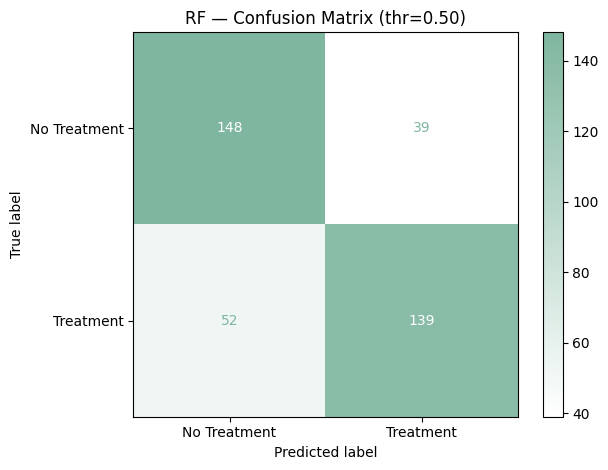

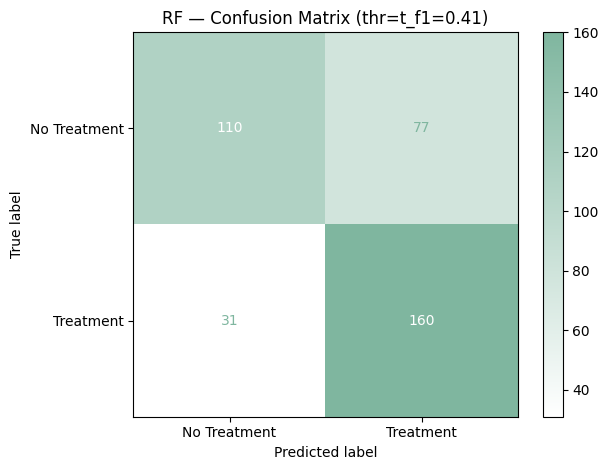

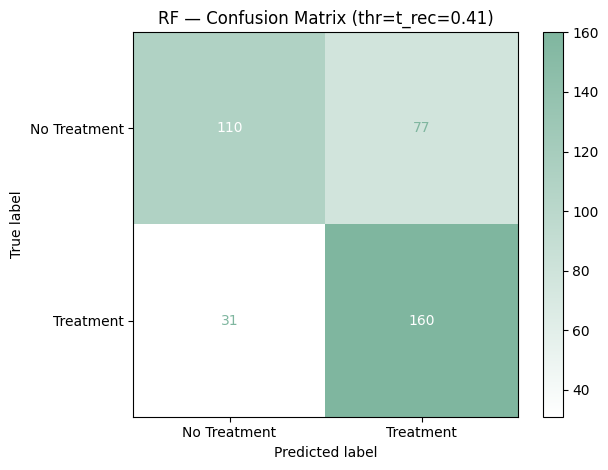

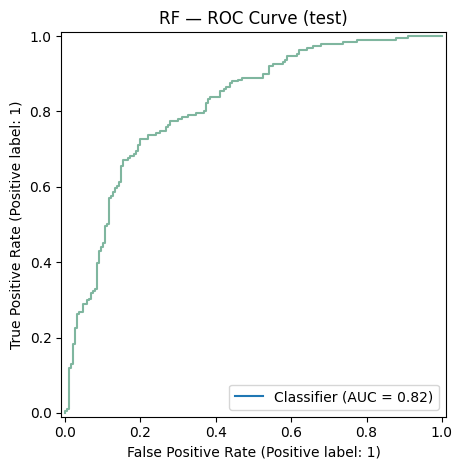

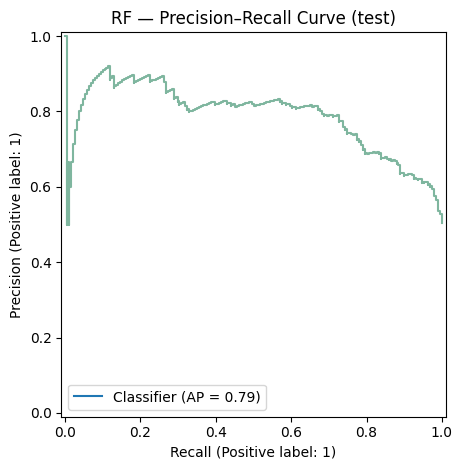

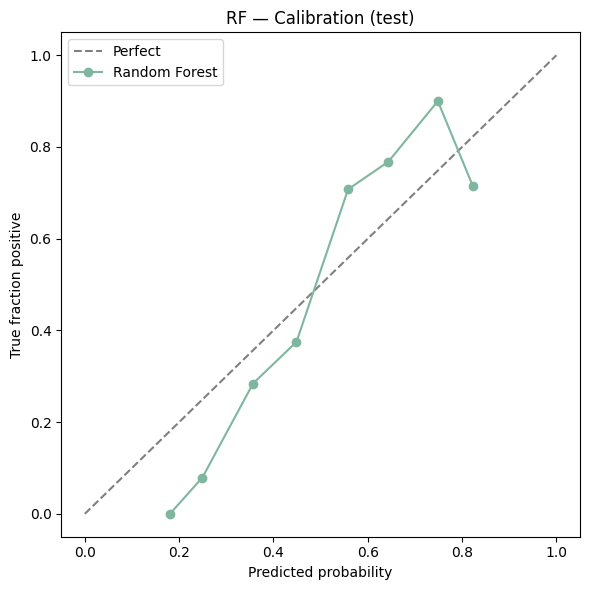

Saved RF model and tables to 'results/'.


In [9]:
# Model 2 — Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, brier_score_loss,
    classification_report, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# Build pipeline
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

# Search space (compact but effective)
rf_param_dist = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None]
}

# Randomized search
search_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=40,
    scoring=PRIMARY_METRIC,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
search_rf.fit(X_train, y_train)

print("Best RF params:", search_rf.best_params_)
print("Best RF CV score:", f"{search_rf.best_score_:.3f}")

best_rf = search_rf.best_estimator_

# Test set evaluation (thr=0.50)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= 0.50).astype(int)

metrics_rf = {
    "roc_auc": roc_auc_score(y_test, y_prob_rf),
    "ap": average_precision_score(y_test, y_prob_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf, zero_division=0),
    "recall": recall_score(y_test, y_pred_rf),
    "brier": brier_score_loss(y_test, y_prob_rf)
}

print("\n=== Random Forest — Test Metrics (thr=0.50) ===")
for k,v in metrics_rf.items():
    print(f"{k}: {v:.3f}")

print("\n=== Classification Report (thr=0.50) ===")
print(classification_report(y_test, y_pred_rf, target_names=["No Treatment","Treatment"]))

# Threshold selection
from sklearn.metrics import precision_recall_curve

def choose_threshold_on_train_from_model(model, X_tr, y_tr, target_recall=0.80):
    y_prob_tr = model.predict_proba(X_tr)[:, 1]
    P, R, T = precision_recall_curve(y_tr, y_prob_tr)
    f1 = (2 * P[:-1] * R[:-1]) / (P[:-1] + R[:-1] + 1e-12)
    t_f1 = float(T[np.nanargmax(f1)])
    idx = np.where(R[:-1] >= target_recall)[0]
    t_rec = None
    if idx.size > 0:
        i_hr = int(idx[np.argmax(f1[idx])])
        t_rec = float(T[i_hr])
    return t_f1, t_rec

t_f1_rf, t_rec_rf = choose_threshold_on_train_from_model(best_rf, X_train, y_train)
print(f"\n[RF] Train-picked thresholds -> t_f1={t_f1_rf:.3f}" + (f", t_rec@0.80={t_rec_rf:.3f}" if t_rec_rf else ""))

def eval_at(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "thr": thr,
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred)
    }

thr_rows_rf = []
thr_rows_rf.append({"scenario":"default_0.50", **eval_at(y_test, y_prob_rf, 0.50)})
thr_rows_rf.append({"scenario":"t_f1(train)", **eval_at(y_test, y_prob_rf, t_f1_rf)})
if t_rec_rf:
    thr_rows_rf.append({"scenario":"t_rec(train)", **eval_at(y_test, y_prob_rf, t_rec_rf)})

thr_table_rf = pd.DataFrame(thr_rows_rf)
print("\n=== RF — Test metrics at thresholds (chosen on train) ===")
display(thr_table_rf)

# Plots

from matplotlib.colors import LinearSegmentedColormap
custom_teal_cmap = LinearSegmentedColormap.from_list("custom_teal", ["#ffffff", "#7FB69F"])

def plot_cm(y_true, y_prob, thr, title):
    ConfusionMatrixDisplay.from_predictions(
        y_true, (y_prob >= thr).astype(int),
        display_labels=["No Treatment","Treatment"],
        cmap=custom_teal_cmap, values_format="d"
    )
    plt.title(title); plt.tight_layout(); plt.show()

plot_cm(y_test, y_prob_rf, 0.50, "RF — Confusion Matrix (thr=0.50)")
plot_cm(y_test, y_prob_rf, t_f1_rf, f"RF — Confusion Matrix (thr=t_f1={t_f1_rf:.2f})")
if t_rec_rf:
    plot_cm(y_test, y_prob_rf, t_rec_rf, f"RF — Confusion Matrix (thr=t_rec={t_rec_rf:.2f})")

roc_disp = RocCurveDisplay.from_predictions(y_test, y_prob_rf)
roc_disp.line_.set_color("#7FB69F")
plt.title("RF — ROC Curve (test)")
plt.tight_layout()
plt.show()


pr_disp = PrecisionRecallDisplay.from_predictions(y_test, y_prob_rf)
pr_disp.line_.set_color("#7FB69F")
plt.title("RF — Precision–Recall Curve (test)")
plt.tight_layout()
plt.show()


prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_prob_rf, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.plot(prob_pred_rf, prob_true_rf, marker="o", label="Random Forest", color="#7FB69F")
plt.xlabel("Predicted probability"); plt.ylabel("True fraction positive")
plt.title("RF — Calibration (test)"); plt.legend(); plt.tight_layout(); plt.show()

#  Persist artifacts
# Save model & threshold table for the report
joblib.dump(best_rf, DIRS["models"]/ "best_rf.joblib")
thr_table_rf.to_csv(DIRS["tables"]/"rf_thresholds.csv", index=False)
pd.DataFrame([search_rf.best_params_]).to_csv(DIRS["tables"]/"rf_best_params.csv", index=False)
print("Saved RF model and tables to 'results/'.")


## Model 3 — Neural Network (Keras)

This section presents a feed-forward Neural Network (NN) constructed using **TensorFlow/Keras** to model treatment-seeking behavior. The categorical encoder in the preprocessing pipeline (`OneHotEncoder`) was configured with `sparse_output=False`, producing dense feature matrices suitable for input into Keras. A cloned version of the preprocessing pipeline is used to ensure independence from previous models.

### Preprocessing for Neural Network

- The preprocessing pipeline is cloned and fitted separately.
- Feature matrices for training and testing are transformed into dense array formats.
- An internal **train–validation split** (85/15) is performed on the training set to support early stopping.

### Network Architecture

The neural network architecture consists of the following:

- An input layer aligned with the feature dimensionality.
- Hidden layers with 128, 64, and 32 neurons respectively, each using ReLU activation.
- **Batch Normalization** and **Dropout (30%)** are applied after each hidden layer to promote regularization and training stability.
- An output layer with a single neuron and **sigmoid** activation function for binary classification.

The model is compiled with the **Adam optimizer** (learning rate = 0.001), using **binary cross-entropy** as the loss function. Evaluation metrics include **ROC-AUC** and **PR-AUC**. **Early stopping** is applied based on validation loss with a patience of 10 epochs, and the best model weights are restored.

### Evaluation at Default Threshold (0.50)

Model performance is evaluated on the test set using a default decision threshold of 0.50. The following metrics are reported:

- **ROC-AUC**, **PR-AUC**, **F1 score**, **Precision**, **Recall**, and **Brier score**.

A classification report is also provided to show precision, recall, and F1 scores for each class ("No Treatment" and "Treatment").

### Threshold Optimization

To improve decision threshold selection, a precision–recall curve is computed on the training data. Two thresholds are derived:

- **`t_f1`**: the threshold that maximizes the F1 score.
- **`t_rec`**: the threshold achieving a recall of at least 0.80 with the highest possible F1 score under that constraint.

Test set metrics are recomputed at these thresholds and compared to the default.

### Visualizations

Several diagnostic plots are generated:

- **Confusion matrices** for thresholds 0.50, `t_f1`, and `t_rec`.
- **ROC curve** and **Precision–Recall curve** for the test set.
- **Calibration curve**, comparing predicted probabilities against actual outcome frequencies.

All plots are presented with consistent formatting for clarity.

### Artifact Preservation

To enable reproducibility:

- The trained neural network is saved in **Keras (.keras)** format.
- The preprocessing pipeline is saved using **Joblib**.
- A CSV file is exported summarizing test set performance at all evaluated thresholds.

Artifacts are stored in the `results/models/` and `results/tables/` directories.



=== Neural Network — Test Metrics (thr=0.50) ===
roc_auc: 0.803
ap: 0.782
f1: 0.706
precision: 0.728
recall: 0.686
brier: 0.183

=== Classification Report (NN, thr=0.50) ===
              precision    recall  f1-score   support

No Treatment       0.70      0.74      0.72       187
   Treatment       0.73      0.69      0.71       191

    accuracy                           0.71       378
   macro avg       0.71      0.71      0.71       378
weighted avg       0.71      0.71      0.71       378


[NN] Train-picked thresholds -> t_f1=0.467, t_rec@0.80=0.467

=== NN — Test metrics at thresholds (chosen on train) ===


,scenario,thr,f1,precision,recall
0,default_0.50,0.500000,0.706199,0.727778,0.685864
1,t_f1(train),0.467275,0.740933,0.733333,0.748691
2,t_rec(train),0.467275,0.740933,0.733333,0.748691


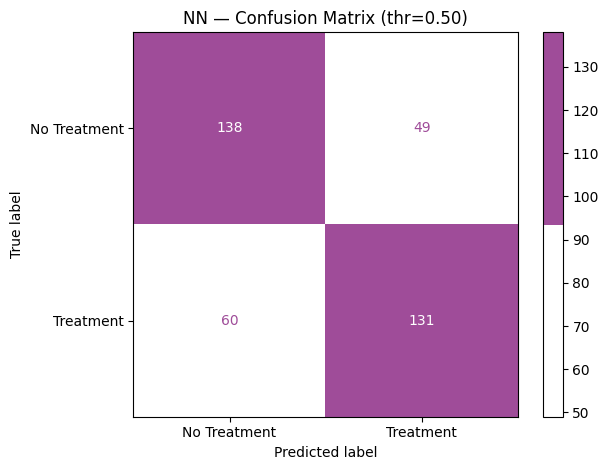

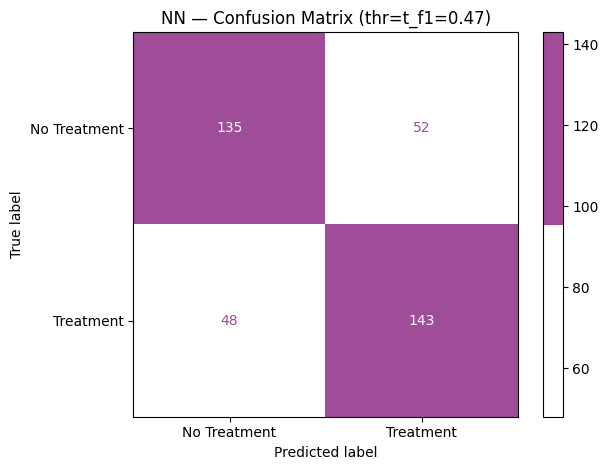

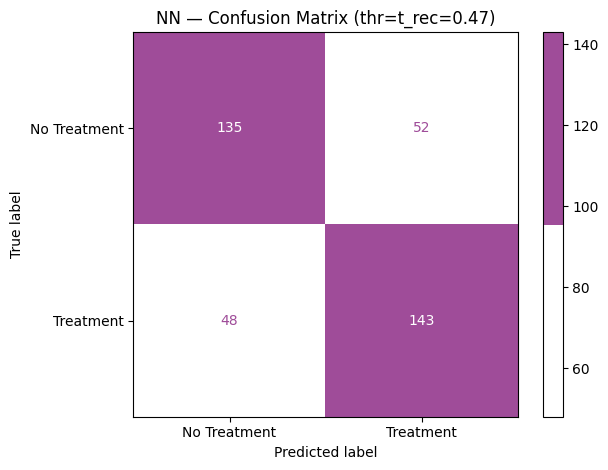

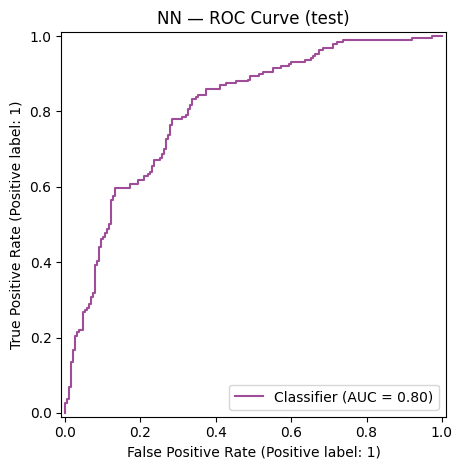

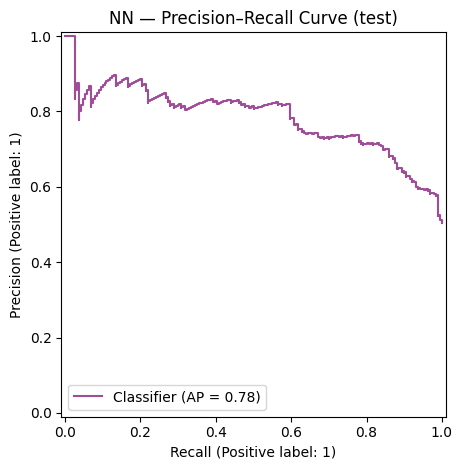

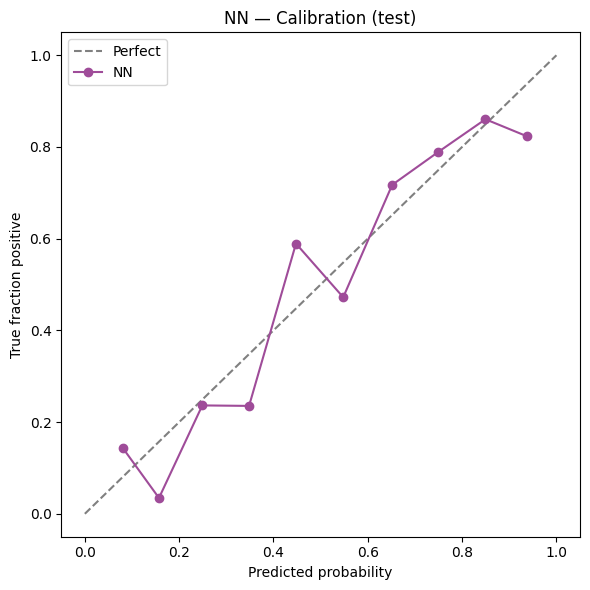

Saved NN model & tables to 'results/'.


In [10]:
# Section 5 — Neural Network (Keras)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, f1_score, precision_score, recall_score,
    average_precision_score, roc_auc_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
import tensorflow as tf
from tensorflow import keras

# fit a dense preprocessor for NN
preprocess_nn = clone(preprocess)
X_train_nn = preprocess_nn.fit_transform(X_train)
X_test_nn  = preprocess_nn.transform(X_test)

# Ensure dense arrays
if hasattr(X_train_nn, "toarray"): X_train_nn = X_train_nn.toarray()
if hasattr(X_test_nn,  "toarray"): X_test_nn  = X_test_nn.toarray()


# Train/val split on TRAIN for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_nn, y_train.values, test_size=0.30, stratify=y_train, random_state=RANDOM_STATE
)

# Define & train NN
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

inp_dim = X_train_nn.shape[1]
inputs = keras.Input(shape=(inp_dim,), name="features")
x = keras.layers.Dense(128, activation="relu")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.30)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.30)(x)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
nn = keras.Model(inputs, outputs, name="mh_treatment_nn")

nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="roc_auc"), keras.metrics.AUC(name="pr_auc", curve="PR")]
)

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
hist = nn.fit(X_tr, y_tr, validation_data=(X_val, y_val),
              epochs=200, batch_size=64, callbacks=[es], verbose=0)


# Predict on TEST @ thr=0.50
y_prob_nn = nn.predict(X_test_nn, verbose=0).ravel()
y_pred_nn = (y_prob_nn >= 0.50).astype(int)

metrics_nn = {
    "roc_auc": roc_auc_score(y_test, y_prob_nn),
    "ap": average_precision_score(y_test, y_prob_nn),
    "f1": f1_score(y_test, y_pred_nn),
    "precision": precision_score(y_test, y_pred_nn, zero_division=0),
    "recall": recall_score(y_test, y_pred_nn),
    "brier": brier_score_loss(y_test, y_prob_nn)
}

print("\n=== Neural Network — Test Metrics (thr=0.50) ===")
for k,v in metrics_nn.items():
    print(f"{k}: {v:.3f}")

print("\n=== Classification Report (NN, thr=0.50) ===")
print(classification_report(y_test, y_pred_nn, target_names=["No Treatment","Treatment"]))

# Train-picked thresholds
from sklearn.metrics import precision_recall_curve


# Get train probabilities using the fitted NN on the preprocessed TRAIN
y_prob_nn_train = nn.predict(X_train_nn, verbose=0).ravel()


def choose_threshold_on_train_from_probs(y_true, y_prob, target_recall=0.80):
    P, R, T = precision_recall_curve(y_true, y_prob)
    f1 = (2 * P[:-1] * R[:-1]) / (P[:-1] + R[:-1] + 1e-12)
    i_best = int(np.nanargmax(f1))
    t_f1 = float(T[i_best])
    t_rec = None
    idx = np.where(R[:-1] >= target_recall)[0]
    if idx.size > 0:
        i_hr = int(idx[np.argmax(f1[idx])])
        t_rec = float(T[i_hr])
    return t_f1, t_rec

t_f1_nn, t_rec_nn = choose_threshold_on_train_from_probs(y_train.values, y_prob_nn_train, target_recall=0.80)
print(f"\n[NN] Train-picked thresholds -> t_f1={t_f1_nn:.3f}" + (f", t_rec@0.80={t_rec_nn:.3f}" if t_rec_nn else ""))


def eval_at(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "thr": thr,
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred)
    }

thr_rows_nn = []
thr_rows_nn.append({"scenario":"default_0.50", **eval_at(y_test, y_prob_nn, 0.50)})
thr_rows_nn.append({"scenario":"t_f1(train)", **eval_at(y_test, y_prob_nn, t_f1_nn)})
if t_rec_nn:
    thr_rows_nn.append({"scenario":"t_rec(train)", **eval_at(y_test, y_prob_nn, t_rec_nn)})

thr_table_nn = pd.DataFrame(thr_rows_nn)
print("\n=== NN — Test metrics at thresholds (chosen on train) ===")
display(thr_table_nn)


# Plots
from matplotlib.colors import ListedColormap
custom_cmap_nn = ListedColormap(["#ffffff", "#9F4C99"])


def plot_cm(y_true, y_prob, thr, title):
    ConfusionMatrixDisplay.from_predictions(
        y_true, (y_prob >= thr).astype(int),
        display_labels=["No Treatment","Treatment"],
        cmap=custom_cmap_nn, values_format="d"
    )
    plt.title(title); plt.tight_layout(); plt.show()

plot_cm(y_test, y_prob_nn, 0.50, "NN — Confusion Matrix (thr=0.50)")
plot_cm(y_test, y_prob_nn, t_f1_nn, f"NN — Confusion Matrix (thr=t_f1={t_f1_nn:.2f})")
if t_rec_nn:
    plot_cm(y_test, y_prob_nn, t_rec_nn, f"NN — Confusion Matrix (thr=t_rec={t_rec_nn:.2f})")

RocCurveDisplay.from_predictions(y_test, y_prob_nn, color="#9F4C99")
plt.title("NN — ROC Curve (test)")
plt.tight_layout()
plt.show()


PrecisionRecallDisplay.from_predictions(y_test, y_prob_nn, color="#9F4C99")
plt.title("NN — Precision–Recall Curve (test)")
plt.tight_layout()
plt.show()

prob_true_nn, prob_pred_nn = calibration_curve(y_test, y_prob_nn, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.plot(prob_pred_nn, prob_true_nn, marker="o", color="#9F4C99", label="NN")
plt.xlabel("Predicted probability"); plt.ylabel("True fraction positive")
plt.title("NN — Calibration (test)"); plt.legend(); plt.tight_layout(); plt.show()


# Save the fitted NN and its preprocessor together
preprocess_nn_path = DIRS["models"]/ "preprocess_nn.joblib"
nn_path = DIRS["models"]/ "nn_model.keras"
import joblib
joblib.dump(preprocess_nn, preprocess_nn_path)
nn.save(nn_path)
thr_table_nn.to_csv(DIRS["tables"]/"nn_thresholds.csv", index=False)
print("Saved NN model & tables to 'results/'.")


### Section 6 — Cross-Model Comparison (Full Features)

We compare Logistic Regression (LR), Random Forest (RF), and Neural Network (NN) on the held-out test set at the default 0.50 threshold. Metrics include F1, Precision, Recall, Accuracy, ROC-AUC, Average Precision (AP), and Brier score. Bootstrapped 95% confidence intervals were also computed for robustness.

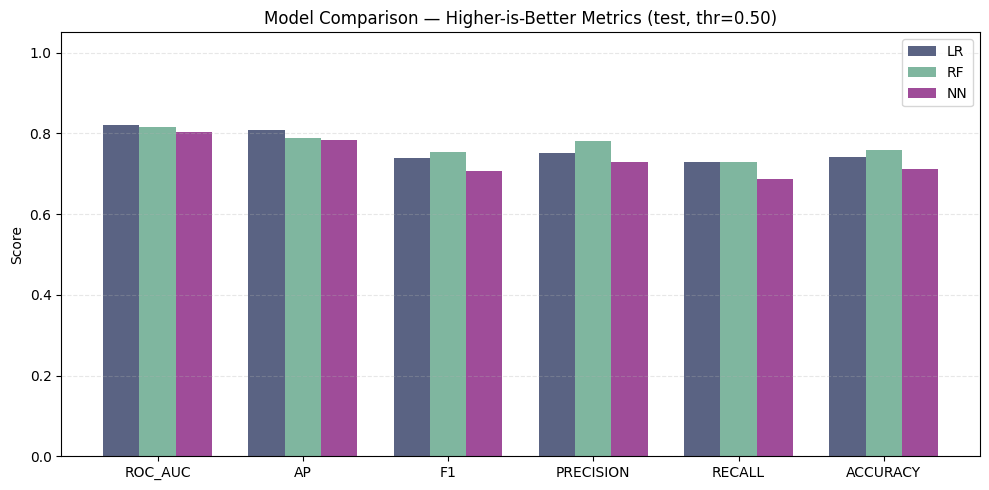

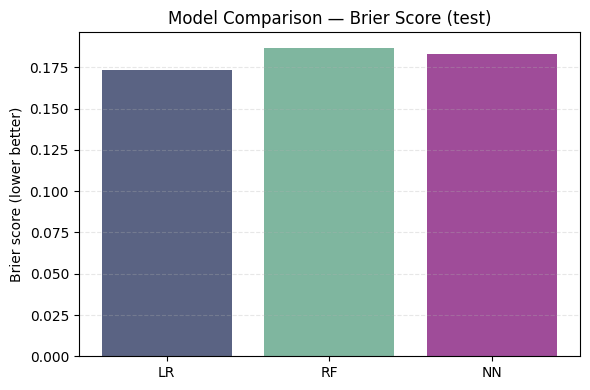

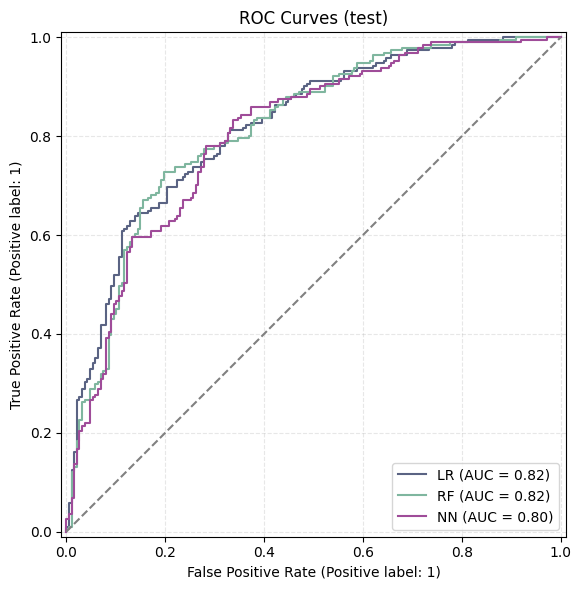

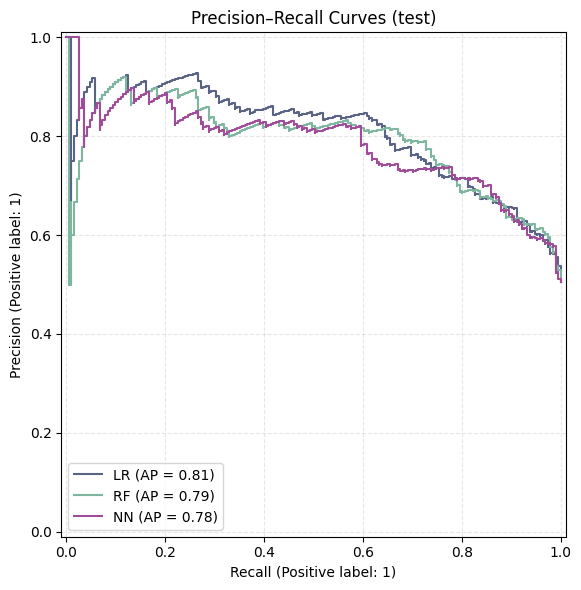

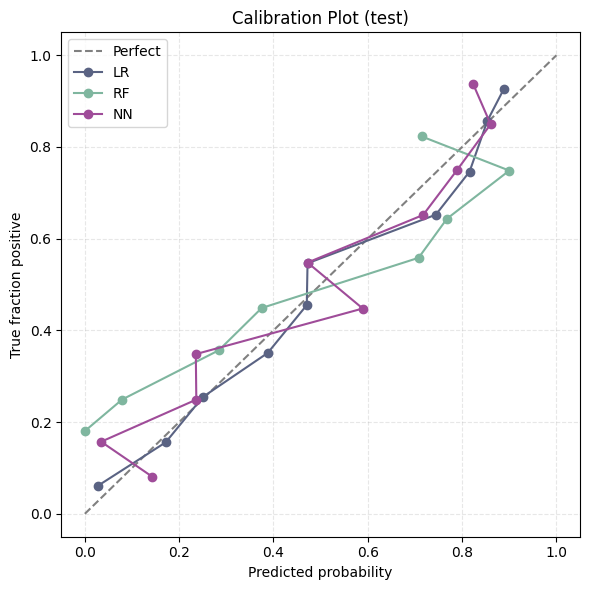

In [11]:
df_cmp = pd.DataFrame.from_dict({
    "LR": metrics_lr,
    "RF": metrics_rf,
    "NN": metrics_nn
}, orient="index")



from sklearn.metrics import accuracy_score

df_cmp["accuracy"] = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_nn)
]



# Custom colors
COLORS = {"LR": "#5A6383", "RF": "#7FB69F", "NN": "#9F4C99"}

#  Grouped bar chart
hi_metrics = ["roc_auc","ap","f1","precision","recall","accuracy"]
labels = [m.upper() if m!="ap" else "AP" for m in hi_metrics]

x = np.arange(len(hi_metrics))
w = 0.25

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - w, df_cmp.loc["LR", hi_metrics].values, w, label="LR", color=COLORS["LR"])
ax.bar(x,      df_cmp.loc["RF", hi_metrics].values, w, label="RF", color=COLORS["RF"])
ax.bar(x + w,  df_cmp.loc["NN", hi_metrics].values, w, label="NN", color=COLORS["NN"])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Model Comparison — Higher-is-Better Metrics (test, thr=0.50)")
ax.legend(); ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(DIRS["figures"]/ "comparison_grouped_bars_high_metrics.png", dpi=200)
plt.show()

# Brier bar chart
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(["LR","RF","NN"], [df_cmp.loc["LR","brier"], df_cmp.loc["RF","brier"], df_cmp.loc["NN","brier"]],
       color=[COLORS["LR"], COLORS["RF"], COLORS["NN"]])
ax.set_ylabel("Brier score (lower better)")
ax.set_title("Model Comparison — Brier Score (test)")
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(DIRS["figures"]/ "comparison_brier.png", dpi=200)
plt.show()



# ROC curves
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="LR", ax=ax, color=COLORS["LR"])
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="RF", ax=ax, color=COLORS["RF"])
RocCurveDisplay.from_predictions(y_test, y_prob_nn, name="NN", ax=ax, color=COLORS["NN"])
ax.plot([0,1],[0,1], "--", color="gray")
ax.set_title("ROC Curves (test)")
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(DIRS["figures"]/ "comparison_roc.png", dpi=200)
plt.show()


#  Precision–Recall curves
fig, ax = plt.subplots(figsize=(6,6))
PrecisionRecallDisplay.from_predictions(y_test, y_prob_lr, name="LR", ax=ax, color=COLORS["LR"])
PrecisionRecallDisplay.from_predictions(y_test, y_prob_rf, name="RF", ax=ax, color=COLORS["RF"])
PrecisionRecallDisplay.from_predictions(y_test, y_prob_nn, name="NN", ax=ax, color=COLORS["NN"])
ax.set_title("Precision–Recall Curves (test)")
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(DIRS["figures"]/ "comparison_pr.png", dpi=200)
plt.show()

# Calibration curves
pLR, tLR = calibration_curve(y_test, y_prob_lr, n_bins=10, strategy="uniform")
pRF, tRF = calibration_curve(y_test, y_prob_rf, n_bins=10, strategy="uniform")
pNN, tNN = calibration_curve(y_test, y_prob_nn, n_bins=10, strategy="uniform")

fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0,1],[0,1], "--", color="gray", label="Perfect")
ax.plot(pLR, tLR, marker="o", color=COLORS["LR"], label="LR")
ax.plot(pRF, tRF, marker="o", color=COLORS["RF"], label="RF")
ax.plot(pNN, tNN, marker="o", color=COLORS["NN"], label="NN")
ax.set_xlabel("Predicted probability"); ax.set_ylabel("True fraction positive")
ax.set_title("Calibration Plot (test)")
ax.legend(); ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig(DIRS["figures"]/ "comparison_calibration.png", dpi=200)
plt.show()


## Section 2 — Feature Reduction & Preprocessing

This section addresses **Research Question 2 (RQ2):**  
*“How does reducing the feature space to the most important variables affect predictive performance in treatment-seeking classification?”*

### Baseline Random Forest
A baseline **Random Forest classifier** with 300 estimators was trained on the full feature set (after one-hot encoding). This model served as the basis for calculating feature importance.

### Permutation Importance
- **Permutation Importance (PI)** was applied to assess the predictive contribution of each feature.  
- Importances from dummy variables were **aggregated back to their original feature names** to avoid bias toward high-cardinality categorical features.  
- Features were ranked by their average importance across 20 permutation repeats.  
- The **top 15 most important features** were selected for the reduced feature space.  

A horizontal bar plot visualises the top predictors.

### Feature Subset
- The dataset was restricted to the **top 15 features** identified by PI.  
- This reduced dataset was used for subsequent model training and evaluation.  
- Outputs (rankings and plots) were saved for reproducibility.  

### Train–Test Split
- A **stratified 70/30 split** was used to preserve the balance between treatment-seeking and non-treatment-seeking cases.  
- The split produced approximately the same positive rate in both training and testing subsets.  

### Column Typing
- **Numeric features:** `age_clean` (if present).  
- **Categorical features:** All other variables in the reduced feature set.  
- This distinction guided the construction of preprocessing pipelines.  

### Preprocessing Pipeline
- **Numeric pipeline:**  
  - Median imputation for missing values.  
  - Standard scaling to normalise magnitudes.  
- **Categorical pipeline:**  
  - Most frequent imputation for missing categories.  
  - One-hot encoding with `handle_unknown="ignore"` and `sparse_output=False`.  

### Cross-Validation
A **Stratified 5-Fold Cross-Validation** object was defined to ensure that:  
- Each fold maintained the same class balance.  
- Model performance was not biased by unbalanced splits.  

### Outputs Saved
- CSV files containing:  
  - Full PI rankings,  
  - Top-15 PI scores,  
  - Reduced schema of numeric vs categorical features.  




Top 15 features selected : ['family_history', 'work_interfere', 'care_options', 'age_clean', 'benefits', 'gender_cleaned', 'mental_health_consequence', 'phys_health_interview', 'no_employees_bucket', 'obs_consequence', 'supervisor', 'wellness_program', 'leave', 'anonymity', 'seek_help']


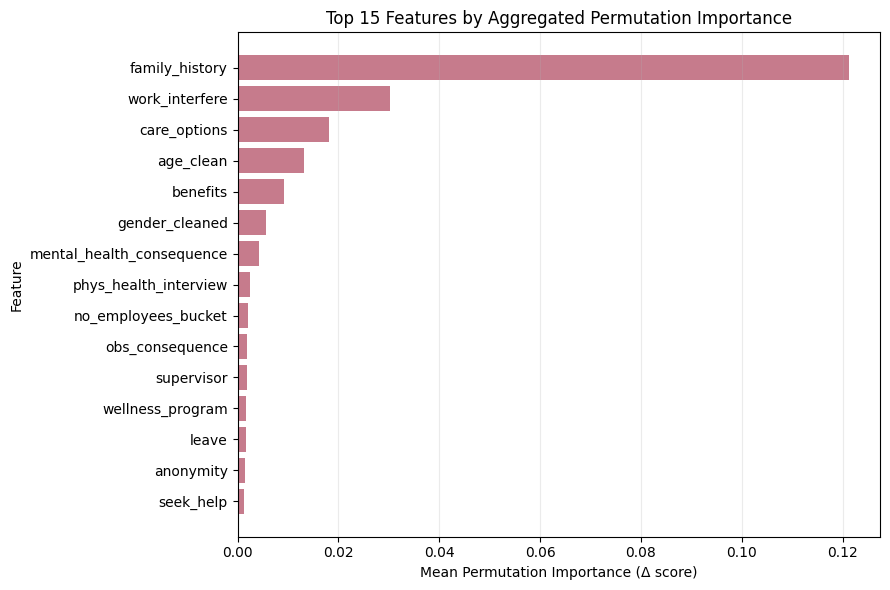

Saved PI tables -> results/tables/permutation_importance_full.csv, results/tables/permutation_importance_top15.csv
Saved PI figure  -> results/figures/perm_importance_top15.png
Train shape: (881, 15) | Test shape: (378, 15)
Target balance in train: 0.506 | in test: 0.505
Numeric cols: ['age_clean']
Categorical cols: ['family_history', 'work_interfere', 'care_options', 'benefits', 'gender_cleaned', 'mental_health_consequence', 'phys_health_interview', 'no_employees_bucket', 'obs_consequence', 'supervisor', 'wellness_program', 'leave', 'anonymity', 'seek_help']
[RQ2 Preprocess ready]
Saved reduced schema -> results/tables/schema_rq2_top15.csv


In [12]:
# ===============================
# Section 2 — Feature Reduction & Preprocessing (Top-15 via Permutation Importance)
# ===============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#Prepare data for PI
assert isinstance(df1, pd.DataFrame), "df1 not found"
assert isinstance(y,  pd.Series),      "y not found"

# Ensure we know the exact target column name (from earlier cleaning code)
target_col = t_col  # you defined this earlier
assert target_col in df1.columns, f"Target column {target_col} not in df1"

# Work on a copy with target removed
df_rq2 = df1.drop(columns=[target_col]).copy()
y_rq2   = y.copy()

# One-hot encode ONCE and keep the design matrix for both fit and PI
Xd = pd.get_dummies(df_rq2, drop_first=True)

# Fit baseline RF and compute permutation importance
rf_baseline = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_baseline.fit(Xd, y_rq2)

perm = permutation_importance(
    rf_baseline,
    Xd, y_rq2,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

#  Aggregate dummy importances back to original features
imp_scores = {}
Xd_cols = Xd.columns.tolist()

for col in df_rq2.columns:
    mask = [(c == col) or c.startswith(col + "_") for c in Xd_cols]
    if any(mask):
        imp_scores[col] = float(np.nanmean(perm.importances_mean[mask]))
    else:
        imp_scores[col] = 0.0

imp_sorted = sorted(imp_scores.items(), key=lambda kv: kv[1], reverse=True)
imp_df     = pd.DataFrame(imp_sorted, columns=["feature", "importance"])

# Select top-15
top15_features = [f for f, s in imp_sorted[:15]]
print("Top 15 features selected :", top15_features)

# Visualize & save PI (Top-15)
imp_df15 = imp_df.head(15).iloc[::-1]
plt.figure(figsize=(9, 6))
plt.barh(imp_df15["feature"], imp_df15["importance"], color="#C67B8C")
plt.xlabel("Mean Permutation Importance (Δ score)")
plt.ylabel("Feature")
plt.title("Top 15 Features by Aggregated Permutation Importance")
plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()

# Save
imp_full_path = DIRS["tables"] / "permutation_importance_full.csv"
imp_top15_path = DIRS["tables"] / "permutation_importance_top15.csv"
fig_path = DIRS["figures"] / "perm_importance_top15.png"

imp_df.to_csv(imp_full_path, index=False)
imp_df15.iloc[::-1].to_csv(imp_top15_path, index=False)
plt.figure(figsize=(9, 6))
plt.barh(imp_df15["feature"], imp_df15["importance"], color="#C67B8C")
plt.xlabel("Mean Permutation Importance (Δ score)")
plt.ylabel("Feature")
plt.title("Top 15 Features by Aggregated Permutation Importance")
plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.close()

print(f"Saved PI tables -> {imp_full_path}, {imp_top15_path}")
print(f"Saved PI figure  -> {fig_path}")

# Subset to Top-15 features & split (70/30 to match your setting)
X_rq2 = df_rq2[top15_features].copy()

X_train_rq2, X_test_rq2, y_train_rq2, y_test_rq2 = train_test_split(
    X_rq2, y_rq2, test_size=0.30, stratify=y_rq2, random_state=RANDOM_STATE
)

print("Train shape:", X_train_rq2.shape, "| Test shape:", X_test_rq2.shape)
print(f"Target balance in train: {y_train_rq2.mean():.3f} | in test: {y_test_rq2.mean():.3f}")

#  Identify column types & build preprocessing for reduced set
num_cols_rq2 = ["age_clean"] if "age_clean" in X_rq2.columns else []
cat_cols_rq2 = [c for c in X_rq2.columns if c not in num_cols_rq2]


# enforce numeric dtype for age_clean if present
if "age_clean" in X_train_rq2:
    X_train_rq2["age_clean"] = pd.to_numeric(X_train_rq2["age_clean"], errors="coerce")
    X_test_rq2["age_clean"]  = pd.to_numeric(X_test_rq2["age_clean"],  errors="coerce")

print("Numeric cols:", num_cols_rq2)
print("Categorical cols:", cat_cols_rq2)


# Use dense OHE so downstream models
cat_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocess_rq2 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols_rq2),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", cat_ohe)
        ]), cat_cols_rq2),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# CV object
cv_rq2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("[RQ2 Preprocess ready]")



# Optional: save the reduced schema for your report/audit
schema_rq2 = pd.DataFrame({
    "feature": num_cols_rq2 + cat_cols_rq2,
    "dtype":   (["numeric"] * len(num_cols_rq2)) + (["categorical"] * len(cat_cols_rq2))
})
schema_rq2_path = DIRS["tables"] / "schema_rq2_top15.csv"
schema_rq2.to_csv(schema_rq2_path, index=False)
print("Saved reduced schema ->", schema_rq2_path)



## Model 1 — Logistic Regression on Reduced Feature Set (RQ2)

This experiment assesses whether a compact subset of predictors (top-15 by aggregated permutation importance) can match or approach the full-feature performance. A regularized Logistic Regression is trained within a preprocessing pipeline (median imputation for numeric, most-frequent for categorical, one-hot encoding), with hyperparameters tuned via 5-fold stratified CV.

### Design
Data restricted to the 15 most important features (from aggregated PI).  

### Tuning
Randomized search over:  
- `C ∈ loguniform[1e-3, 1e2]`  
- `penalty ∈ {l1, l2}`  
- `solver ∈ {liblinear, saga}`  

Scoring metric: **F1**.

### Evaluation
Metrics reported on the test set:  
- ROC-AUC  
- Average Precision (AP)  
- F1  
- Precision  
- Recall  
- Brier score  

at the default threshold **0.50**, plus thresholds chosen on training data:  
- **t_f1**: threshold that maximizes F1 on the train set.  
- **t_rec @0.80**: highest-F1 threshold among those achieving ≥0.80 recall on train.

### Visuals
- Confusion matrices at thresholds (0.50, t_f1, t_rec@0.80)  
- ROC curve  
- PR curve  
- Calibration plot  

### Interpretation
- Use the threshold table to discuss **precision–recall trade-offs** under different operating points.
- Use the **calibration curve** to comment on the reliability of predicted probabilities when supporting downstream decisions.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (RQ2 LR): {'clf__C': np.float64(0.11055837511532204), 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best CV F1 (RQ2 LR): 0.766

=== Logistic Regression (RQ2) — Test Metrics (thr=0.50) ===
roc_auc: 0.815
ap: 0.801
f1: 0.753
precision: 0.763
recall: 0.743
brier: 0.177

=== Classification Report (RQ2, thr=0.50) ===
              precision    recall  f1-score   support

No Treatment       0.74      0.76      0.75       187
   Treatment       0.76      0.74      0.75       191

    accuracy                           0.75       378
   macro avg       0.75      0.75      0.75       378
weighted avg       0.75      0.75      0.75       378


[RQ2 LR] Train-picked thresholds -> t_f1=0.419, t_rec@0.80=0.419

=== LR (RQ2) — Test metrics at thresholds (chosen on train) ===


,scenario,thr,f1,precision,recall
0,default_0.50,0.500000,0.753316,0.763441,0.743455
1,t_f1(train),0.419156,0.759804,0.714286,0.811518
2,t_rec(train),0.419156,0.759804,0.714286,0.811518


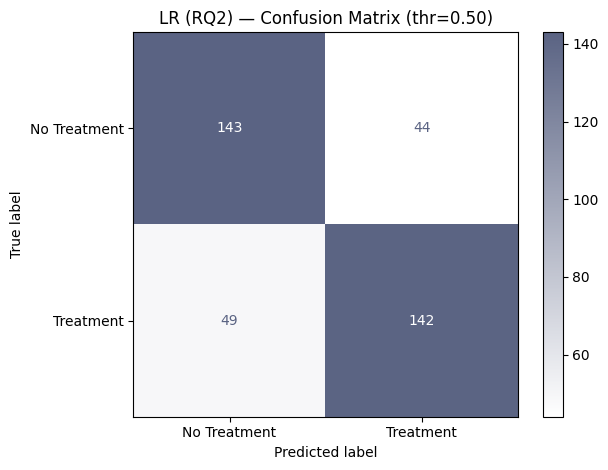

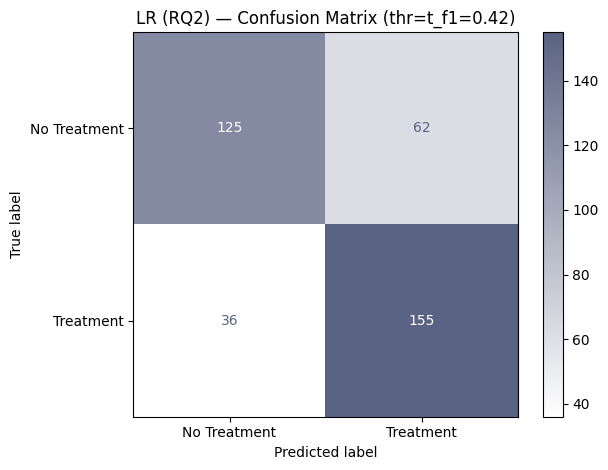

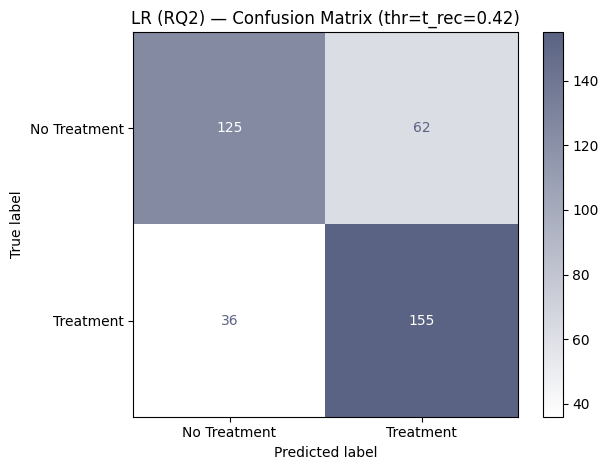

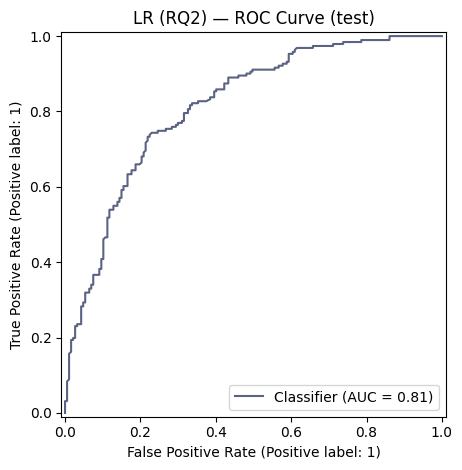

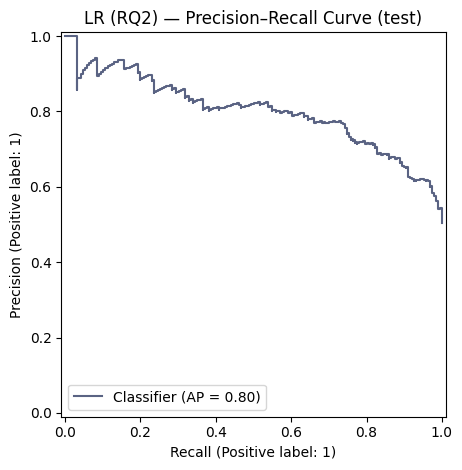

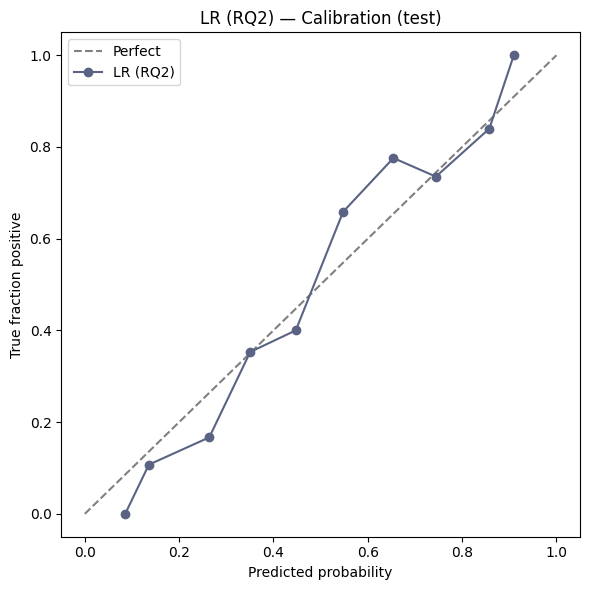

In [13]:
# Model 1 — Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, brier_score_loss,
    classification_report, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#  Pipeline
logreg_pipe_rq2 = Pipeline([
    ("preprocess", preprocess_rq2),
    ("clf", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))
])



param_dist_rq2 = {
    "clf__C": loguniform(1e-3, 1e2),
    "clf__penalty": ["l1", "l2"],
    "clf__solver": ["liblinear", "saga"]
}


#  Randomized search with CV
search_lr_rq2 = RandomizedSearchCV(
    estimator=logreg_pipe_rq2,
    param_distributions=param_dist_rq2,
    n_iter=40,
    scoring="f1",
    cv=cv_rq2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
search_lr_rq2.fit(X_train_rq2, y_train_rq2)

print("Best params (RQ2 LR):", search_lr_rq2.best_params_)
print("Best CV F1 (RQ2 LR):", f"{search_lr_rq2.best_score_:.3f}")

best_lr_rq2 = search_lr_rq2.best_estimator_


# Test evaluation (thr=0.50)
y_prob_lr_rq2 = best_lr_rq2.predict_proba(X_test_rq2)[:, 1]
y_pred_lr_rq2 = (y_prob_lr_rq2 >= 0.50).astype(int)

metrics_lr_rq2 = {
    "roc_auc": roc_auc_score(y_test_rq2, y_prob_lr_rq2),
    "ap": average_precision_score(y_test_rq2, y_prob_lr_rq2),
    "f1": f1_score(y_test_rq2, y_pred_lr_rq2),
    "precision": precision_score(y_test_rq2, y_pred_lr_rq2, zero_division=0),
    "recall": recall_score(y_test_rq2, y_pred_lr_rq2),
    "brier": brier_score_loss(y_test_rq2, y_prob_lr_rq2)
}

print("\n=== Logistic Regression (RQ2) — Test Metrics (thr=0.50) ===")
for k,v in metrics_lr_rq2.items():
    print(f"{k}: {v:.3f}")

print("\n=== Classification Report (RQ2, thr=0.50) ===")
print(classification_report(y_test_rq2, y_pred_lr_rq2, target_names=["No Treatment","Treatment"]))

#  Threshold tuning
from sklearn.metrics import precision_recall_curve

def choose_threshold_on_train_rq2(model, X_tr, y_tr, target_recall=0.80):
    y_prob_tr = model.predict_proba(X_tr)[:, 1]
    P, R, T = precision_recall_curve(y_tr, y_prob_tr)
    f1 = (2 * P[:-1] * R[:-1]) / (P[:-1] + R[:-1] + 1e-12)
    t_f1 = float(T[np.nanargmax(f1)])  # threshold for best F1
    idx = np.where(R[:-1] >= target_recall)[0]
    t_rec = None
    if idx.size > 0:
        i_hr = int(idx[np.argmax(f1[idx])])
        t_rec = float(T[i_hr])
    return t_f1, t_rec

t_f1_lr_rq2, t_rec_lr_rq2 = choose_threshold_on_train_rq2(best_lr_rq2, X_train_rq2, y_train_rq2)

print(f"\n[RQ2 LR] Train-picked thresholds -> t_f1={t_f1_lr_rq2:.3f}" + (f", t_rec@0.80={t_rec_lr_rq2:.3f}" if t_rec_lr_rq2 else ""))


# Evaluate at multiple thresholds
def eval_at_rq2(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "thr": thr,
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred)
    }

thr_rows_lr_rq2 = []
thr_rows_lr_rq2.append({"scenario":"default_0.50", **eval_at_rq2(y_test_rq2, y_prob_lr_rq2, 0.50)})
thr_rows_lr_rq2.append({"scenario":"t_f1(train)", **eval_at_rq2(y_test_rq2, y_prob_lr_rq2, t_f1_lr_rq2)})
if t_rec_lr_rq2:
    thr_rows_lr_rq2.append({"scenario":"t_rec(train)", **eval_at_rq2(y_test_rq2, y_prob_lr_rq2, t_rec_lr_rq2)})

thr_table_lr_rq2 = pd.DataFrame(thr_rows_lr_rq2)
print("\n=== LR (RQ2) — Test metrics at thresholds (chosen on train) ===")
display(thr_table_lr_rq2)

# Plots
from matplotlib.colors import LinearSegmentedColormap

LR_COLOR = "#5A6383"
cmapspec = LinearSegmentedColormap.from_list("lr_map", ["#ffffff", LR_COLOR])

def plot_cm_rq2(y_true, y_prob, thr, title):
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        (y_prob >= thr).astype(int),
        display_labels=["No Treatment","Treatment"],
        cmap=cmapspec,
        values_format="d"
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Confusion matrices
plot_cm_rq2(y_test_rq2, y_prob_lr_rq2, 0.50, "LR (RQ2) — Confusion Matrix (thr=0.50)")
plot_cm_rq2(y_test_rq2, y_prob_lr_rq2, t_f1_lr_rq2, f"LR (RQ2) — Confusion Matrix (thr=t_f1={t_f1_lr_rq2:.2f})")
if t_rec_lr_rq2 is not None:
    plot_cm_rq2(y_test_rq2, y_prob_lr_rq2, t_rec_lr_rq2, f"LR (RQ2) — Confusion Matrix (thr=t_rec={t_rec_lr_rq2:.2f})")

# ROC and PR curves
RocCurveDisplay.from_predictions(y_test_rq2, y_prob_lr_rq2, color=LR_COLOR)
plt.title("LR (RQ2) — ROC Curve (test)")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test_rq2, y_prob_lr_rq2, color=LR_COLOR)
plt.title("LR (RQ2) — Precision–Recall Curve (test)")
plt.tight_layout()
plt.show()

# Calibration plot
prob_true_rq2, prob_pred_rq2 = calibration_curve(y_test_rq2, y_prob_lr_rq2, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.plot(prob_pred_rq2, prob_true_rq2, marker="o", color=LR_COLOR, label="LR (RQ2)")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("LR (RQ2) — Calibration (test)")
plt.legend()
plt.tight_layout()
plt.show()

## Model 2 — Random Forest on Reduced Feature Set (RQ2)

This experiment evaluates the Random Forest classifier trained only on the **top-15 features** identified by aggregated permutation importance. The goal is to assess whether reducing the feature space still maintains competitive predictive performance.

### Design
- **Data:** Reduced to the 15 most important features.  
- **Pipeline:**  
  - `age_clean` → median imputation + scaling.  
  - Categorical → most-frequent imputation + one-hot encoding.  
- **Cross-validation:** Stratified 5-fold CV for hyperparameter tuning.

### Hyperparameter Tuning
A RandomizedSearchCV (40 iterations) was used with F1 as the scoring metric. The search space included:  
- `n_estimators ∈ {200, 400, 600, 800, 1000}`  
- `max_depth ∈ {5, 10, 15, 20, None}`  
- `max_features ∈ {sqrt, log2, None}`  
- `min_samples_split ∈ {2, 5, 10}`  
- `min_samples_leaf ∈ {1, 2, 4}`  

The best parameters and CV F1 score were reported.

### Evaluation
On the test set, the model was evaluated using:  
- **ROC-AUC**  
- **Average Precision (AP)**  
- **F1 score**  
- **Precision**  
- **Recall**  
- **Brier score**  

Performance was reported at:  
- Default threshold **0.50**  
- Train-picked threshold **t_f1** (maximizes F1)  
- Train-picked threshold **t_rec @0.80** (best F1 among thresholds with recall ≥ 0.80)

### Visuals
- Confusion matrices at thresholds (0.50, t_f1, t_rec @0.80)  
- ROC curve (test set)  
- Precision–Recall curve (test set)  
- Calibration curve (test set)  
.



Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params (RQ2 RF): {'clf__n_estimators': 400, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': 5}
Best CV F1 (RQ2 RF): 0.765

=== Random Forest (RQ2) — Test Metrics (thr=0.50) ===
roc_auc: 0.809
ap: 0.784
f1: 0.743
precision: 0.777
recall: 0.712
brier: 0.186

=== Classification Report (RQ2 RF, thr=0.50) ===
              precision    recall  f1-score   support

No Treatment       0.73      0.79      0.76       187
   Treatment       0.78      0.71      0.74       191

    accuracy                           0.75       378
   macro avg       0.75      0.75      0.75       378
weighted avg       0.75      0.75      0.75       378


[RQ2 RF] Train-picked thresholds -> t_f1=0.400, t_rec@0.80=0.400

=== RQ2 RF — Test metrics at thresholds (chosen on train) ===


,scenario,thr,f1,precision,recall
0,default_0.50,0.500000,0.743169,0.777143,0.712042
1,t_f1(train),0.400251,0.740566,0.673820,0.821990
2,t_rec(train),0.400251,0.740566,0.673820,0.821990


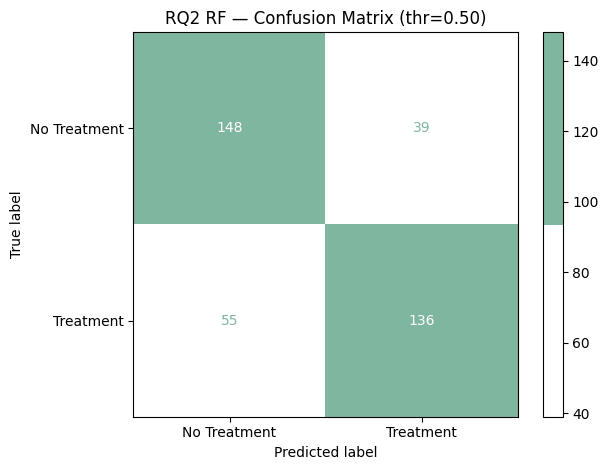

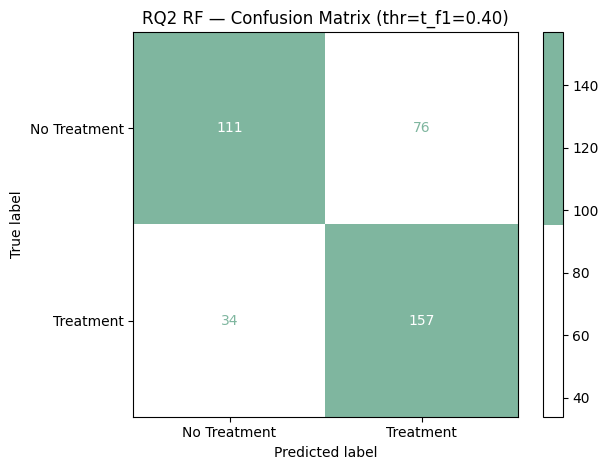

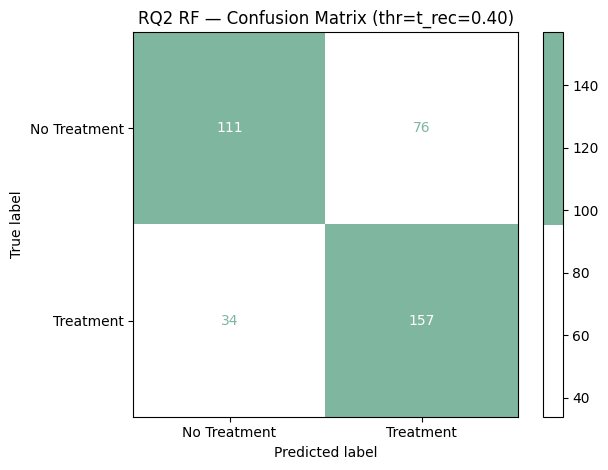

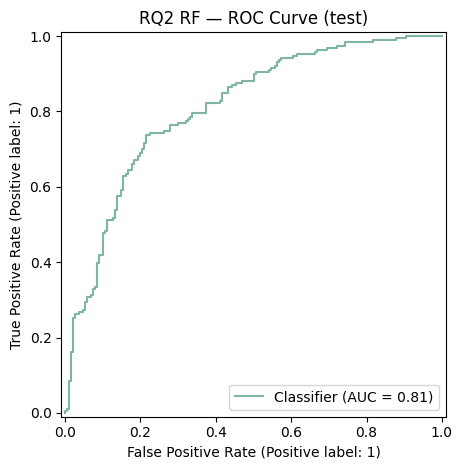

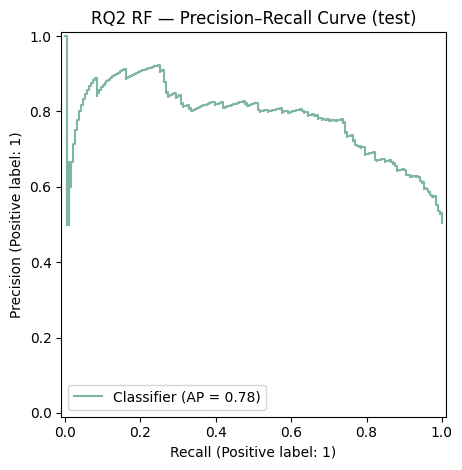

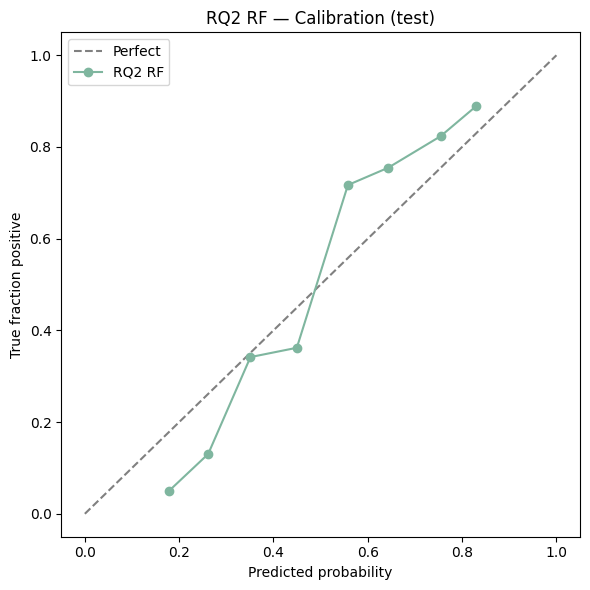

Saved RQ2 RF model and tables to 'results/'.


In [14]:
# Model 2 — Random Forest (RQ2)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, brier_score_loss,
    classification_report, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)
from sklearn.calibration import calibration_curve
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib


def choose_threshold_on_train_from_probs_rq2(y_true, y_probs, target_recall=0.80):
    """
    Returns:
      t_f1  – threshold that maximizes F1 on TRAIN
      t_rec – best-F1 threshold among those with recall ≥ target_recall (or None)
    """
    y_true = np.asarray(y_true, dtype=int)
    y_probs = np.asarray(y_probs, dtype=float)

    P, R, T = precision_recall_curve(y_true, y_probs)
    if T.size == 0:
        return 0.50, None


    P, R = P[:-1], R[:-1]
    f1 = (2 * P * R) / (P + R + 1e-12)

    i_best = int(np.nanargmax(f1))
    t_f1 = float(T[i_best])

    t_rec = None
    hi = np.where(R >= target_recall)[0]
    if hi.size > 0:
        i_hr = hi[np.argmax(f1[hi])]
        t_rec = float(T[i_hr])

    return t_f1, t_rec

def eval_at_rq2(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "thr": float(thr),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred)
    }

def plot_cm_rq2(y_true, y_prob, thr, title, color_hex="#7FB69F"):

    cmap = ListedColormap(["#ffffff", color_hex])
    ConfusionMatrixDisplay.from_predictions(
        y_true, (y_prob >= thr).astype(int),
        display_labels=["No Treatment","Treatment"],
        cmap=cmap, values_format="d"
    )
    plt.title(title); plt.tight_layout(); plt.show()


# Pipeline

rf_rq2_pipe = Pipeline([
    ("preprocess", preprocess_rq2),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
])

param_dist_rf_rq2 = {
    "clf__n_estimators": [200, 400, 600, 800, 1000],
    "clf__max_depth": [5, 10, 15, 20, None],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

search_rf_rq2 = RandomizedSearchCV(
    estimator=rf_rq2_pipe,
    param_distributions=param_dist_rf_rq2,
    n_iter=40,
    scoring="f1",
    cv=cv_rq2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
search_rf_rq2.fit(X_train_rq2, y_train_rq2)

print("Best params (RQ2 RF):", search_rf_rq2.best_params_)
print("Best CV F1 (RQ2 RF):", f"{search_rf_rq2.best_score_:.3f}")

best_rf_rq2 = search_rf_rq2.best_estimator_


# Test evaluation

y_prob_rf_rq2 = best_rf_rq2.predict_proba(X_test_rq2)[:, 1]
y_pred_rf_rq2 = (y_prob_rf_rq2 >= 0.50).astype(int)

metrics_rf_rq2 = {
    "roc_auc": roc_auc_score(y_test_rq2, y_prob_rf_rq2),
    "ap": average_precision_score(y_test_rq2, y_prob_rf_rq2),
    "f1": f1_score(y_test_rq2, y_pred_rf_rq2),
    "precision": precision_score(y_test_rq2, y_pred_rf_rq2, zero_division=0),
    "recall": recall_score(y_test_rq2, y_pred_rf_rq2),
    "brier": brier_score_loss(y_test_rq2, y_prob_rf_rq2)
}
print("\n=== Random Forest (RQ2) — Test Metrics (thr=0.50) ===")
for k, v in metrics_rf_rq2.items():
    print(f"{k}: {v:.3f}")

print("\n=== Classification Report (RQ2 RF, thr=0.50) ===")
print(classification_report(y_test_rq2, y_pred_rf_rq2, target_names=["No Treatment","Treatment"]))


# Thresholds

y_prob_rf_rq2_train = best_rf_rq2.predict_proba(X_train_rq2)[:, 1]
t_f1_rf_rq2, t_rec_rf_rq2 = choose_threshold_on_train_from_probs_rq2(
    y_train_rq2, y_prob_rf_rq2_train, target_recall=0.80
)
print(f"\n[RQ2 RF] Train-picked thresholds -> t_f1={t_f1_rf_rq2:.3f}" +
      (f", t_rec@0.80={t_rec_rf_rq2:.3f}" if t_rec_rf_rq2 is not None else ""))

thr_rows_rf_rq2 = []
thr_rows_rf_rq2.append({"scenario": "default_0.50", **eval_at_rq2(y_test_rq2, y_prob_rf_rq2, 0.50)})
thr_rows_rf_rq2.append({"scenario": "t_f1(train)", **eval_at_rq2(y_test_rq2, y_prob_rf_rq2, t_f1_rf_rq2)})
if t_rec_rf_rq2 is not None:
    thr_rows_rf_rq2.append({"scenario": "t_rec(train)", **eval_at_rq2(y_test_rq2, y_prob_rf_rq2, t_rec_rf_rq2)})

thr_table_rf_rq2 = pd.DataFrame(thr_rows_rf_rq2)
print("\n=== RQ2 RF — Test metrics at thresholds (chosen on train) ===")
display(thr_table_rf_rq2)


# Plots

plot_cm_rq2(y_test_rq2, y_prob_rf_rq2, 0.50, "RQ2 RF — Confusion Matrix (thr=0.50)", color_hex="#7FB69F")
plot_cm_rq2(y_test_rq2, y_prob_rf_rq2, t_f1_rf_rq2, f"RQ2 RF — Confusion Matrix (thr=t_f1={t_f1_rf_rq2:.2f})", color_hex="#7FB69F")
if t_rec_rf_rq2 is not None:
    plot_cm_rq2(y_test_rq2, y_prob_rf_rq2, t_rec_rf_rq2, f"RQ2 RF — Confusion Matrix (thr=t_rec={t_rec_rf_rq2:.2f})", color_hex="#7FB69F")

RocCurveDisplay.from_predictions(y_test_rq2, y_prob_rf_rq2, color="#7FB69F")
plt.title("RQ2 RF — ROC Curve (test)"); plt.tight_layout(); plt.show()

PrecisionRecallDisplay.from_predictions(y_test_rq2, y_prob_rf_rq2, color="#7FB69F")
plt.title("RQ2 RF — Precision–Recall Curve (test)"); plt.tight_layout(); plt.show()

prob_true_rf_rq2, prob_pred_rf_rq2 = calibration_curve(y_test_rq2, y_prob_rf_rq2, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.plot(prob_pred_rf_rq2, prob_true_rf_rq2, marker="o", color="#7FB69F", label="RQ2 RF")
plt.xlabel("Predicted probability"); plt.ylabel("True fraction positive")
plt.title("RQ2 RF — Calibration (test)"); plt.legend(); plt.tight_layout(); plt.show()


# save
try:
    joblib.dump(best_rf_rq2, DIRS["models"]/ "best_rf_rq2.joblib")
    thr_table_rf_rq2.to_csv(DIRS["tables"]/"rq2_rf_thresholds.csv", index=False)
    pd.DataFrame([search_rf_rq2.best_params_]).to_csv(DIRS["tables"]/"rq2_rf_best_params.csv", index=False)
    print("Saved RQ2 RF model and tables to 'results/'.")
except Exception as e:
    print(" Skipped saving artifacts (DIRS missing or path issue):", e)


## Model 3 — Neural Network on Reduced Feature Set (RQ2)

This experiment investigates whether a feed-forward Neural Network can leverage the **top-15 features** (from aggregated permutation importance) to match or outperform traditional models on treatment-seeking prediction.

### Design
- **Data:** Restricted to 15 most important features.  
- **Preprocessing:**  
  - Categorical variables → impute (most frequent) + one-hot encode.  
  - Resulting arrays explicitly converted to dense format for Keras.  
- **Train/Validation Split:** 85/15 stratified, taken from the training set.  

### Model Architecture
- Input layer: size = number of preprocessed features.  
- Hidden layers:  
  - Dense(128, ReLU) → BatchNorm → Dropout(0.3)  
  - Dense(64, ReLU) → BatchNorm → Dropout(0.3)  
  - Dense(32, ReLU)  
- Output: Dense(1, sigmoid).  
- Optimizer: Adam (lr=1e-3), loss = binary cross-entropy.  
- Metrics: ROC-AUC, PR-AUC.  
- Early stopping with patience = 10 epochs.

### Evaluation
Reported test metrics:  
- ROC-AUC  
- Average Precision (AP)  
- F1 score  
- Precision  
- Recall  
- Brier score  

Threshold tuning applied using training probabilities:  
- **t_f1:** maximizes F1.  
- **t_rec @0.80:** highest F1 among thresholds achieving ≥0.80 recall.  

### Visuals
- Confusion matrices at thresholds (0.50, t_f1, t_rec@0.80).  
- ROC curve (test set).  
- Precision–Recall curve (test set).  
- Calibration curve (test set).  




12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== Neural Network (RQ2) — Test Metrics (thr=0.50) ===
roc_auc: 0.781
ap: 0.762
f1: 0.592
precision: 0.767
recall: 0.482
brier: 0.205

=== Classification Report (RQ2 NN, thr=0.50) ===
              precision    recall  f1-score   support

No Treatment       0.62      0.85      0.71       187
   Treatment       0.77      0.48      0.59       191

    accuracy                           0.66       378
   macro avg       0.69      0.67      0.65       378
weighted avg       0.69      0.66      0.65       378

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

[RQ2 NN] Train-picked thresholds -> t_f1=0.350, t_rec@0.80=0.350

=== RQ2 NN — Test metrics at thresholds (chosen on train) ===


,scenario,thr,f1,precision,recall
0,default_0.50,0.500000,0.591640,0.766667,0.481675
1,t_f1(train),0.349754,0.739454,0.702830,0.780105
2,t_rec(train),0.349754,0.739454,0.702830,0.780105


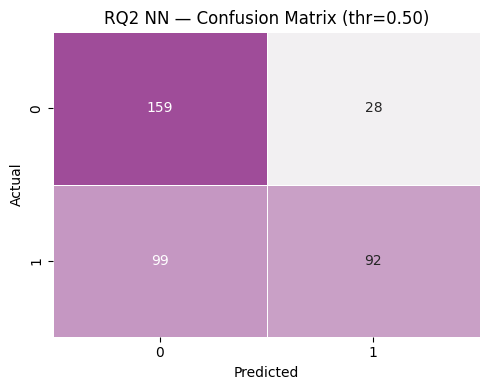

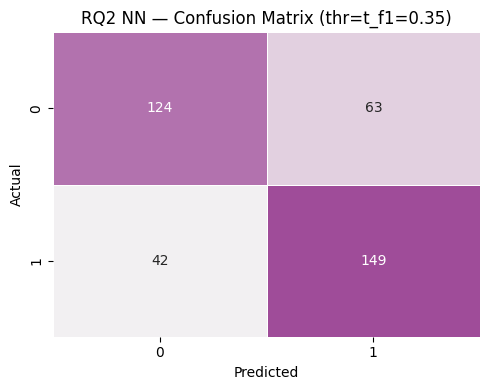

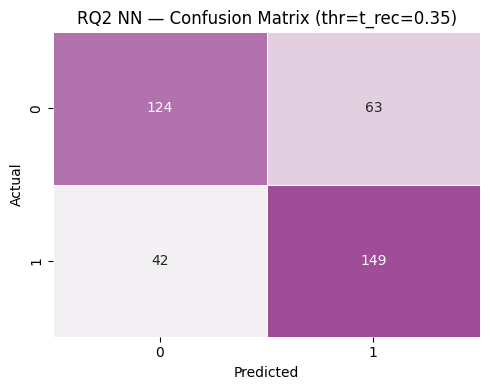

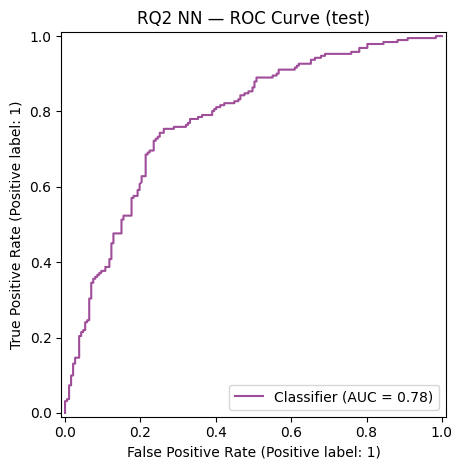

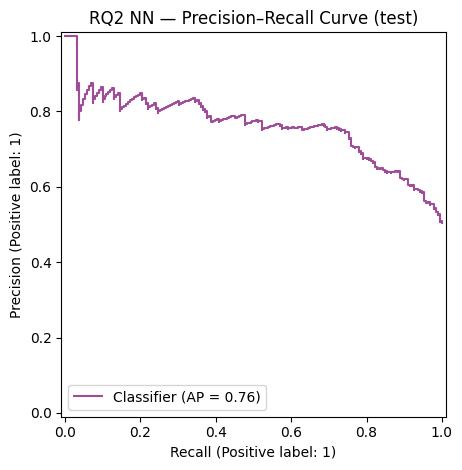

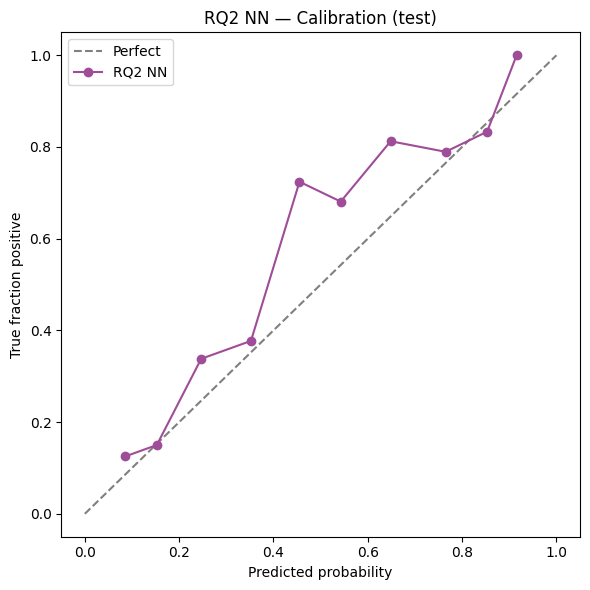

In [15]:
# Model 3 — Neural Network (RQ2)
import tensorflow as tf
from tensorflow import keras


#  Preprocess for NN
dense_num_tf_rq2 = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
dense_cat_tf_rq2 = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])


# Separate numeric and categorical columns properly
numeric_cols_nn_rq2 = ["age_clean"] if "age_clean" in X_train_rq2.columns else []
categorical_cols_nn_rq2 = [c for c in X_train_rq2.columns if c not in numeric_cols_nn_rq2]

# Pipelines
dense_num_tf_rq2 = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
dense_cat_tf_rq2 = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer that keeps both numeric + categorical
preprocess_dense_nn_rq2 = ColumnTransformer([
    ("num", dense_num_tf_rq2, numeric_cols_nn_rq2),
    ("cat", dense_cat_tf_rq2, categorical_cols_nn_rq2),
], remainder="drop", verbose_feature_names_out=False)

# Apply preprocessing
X_train_nn_rq2 = preprocess_dense_nn_rq2.fit_transform(X_train_rq2)
X_test_nn_rq2  = preprocess_dense_nn_rq2.transform(X_test_rq2)

# Ensure dense arrays
if hasattr(X_train_nn_rq2, "toarray"):
    X_train_nn_rq2 = X_train_nn_rq2.toarray()
    X_test_nn_rq2  = X_test_nn_rq2.toarray()

preprocess_dense_nn_rq2 = ColumnTransformer([
    ("cat", dense_cat_tf_rq2, categorical_cols_nn_rq2),
], remainder="drop", verbose_feature_names_out=False)

X_train_nn_rq2 = preprocess_dense_nn_rq2.fit_transform(X_train_rq2)
X_test_nn_rq2  = preprocess_dense_nn_rq2.transform(X_test_rq2)

if hasattr(X_train_nn_rq2, "toarray"):  # ensure dense
    X_train_nn_rq2 = X_train_nn_rq2.toarray()
    X_test_nn_rq2  = X_test_nn_rq2.toarray()


# Train/val split
X_tr_rq2, X_val_rq2, y_tr_rq2, y_val_rq2 = train_test_split(
    X_train_nn_rq2, y_train_rq2.values, test_size=0.30,
    stratify=y_train_rq2, random_state=RANDOM_STATE
)


# Define NN
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

inp_dim = X_train_nn_rq2.shape[1]
inputs = keras.Input(shape=(inp_dim,), name="features")
x = keras.layers.Dense(128, activation="relu")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
nn_rq2 = keras.Model(inputs, outputs, name="rq2_nn")

nn_rq2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="roc_auc"), keras.metrics.AUC(name="pr_auc", curve="PR")]
)

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

hist_rq2 = nn_rq2.fit(
    X_tr_rq2, y_tr_rq2,
    validation_data=(X_val_rq2, y_val_rq2),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=0
)


#  Predictions
y_prob_nn_rq2 = nn_rq2.predict(X_test_nn_rq2).ravel()
y_pred_nn_rq2 = (y_prob_nn_rq2 >= 0.50).astype(int)

metrics_nn_rq2 = {
    "roc_auc": roc_auc_score(y_test_rq2, y_prob_nn_rq2),
    "ap": average_precision_score(y_test_rq2, y_prob_nn_rq2),
    "f1": f1_score(y_test_rq2, y_pred_nn_rq2),
    "precision": precision_score(y_test_rq2, y_pred_nn_rq2, zero_division=0),
    "recall": recall_score(y_test_rq2, y_pred_nn_rq2),
    "brier": brier_score_loss(y_test_rq2, y_prob_nn_rq2)
}

print("\n=== Neural Network (RQ2) — Test Metrics (thr=0.50) ===")
for k,v in metrics_nn_rq2.items():
    print(f"{k}: {v:.3f}")

print("\n=== Classification Report (RQ2 NN, thr=0.50) ===")
print(classification_report(y_test_rq2, y_pred_nn_rq2, target_names=["No Treatment","Treatment"]))


#  Threshold tuning
y_prob_nn_train_rq2 = nn_rq2.predict(X_train_nn_rq2).ravel()
t_f1_nn_rq2, t_rec_nn_rq2 = choose_threshold_on_train_from_probs_rq2(y_train_rq2.values, y_prob_nn_train_rq2)

print(f"\n[RQ2 NN] Train-picked thresholds -> t_f1={t_f1_nn_rq2:.3f}" +
      (f", t_rec@0.80={t_rec_nn_rq2:.3f}" if t_rec_nn_rq2 else ""))

thr_rows_nn_rq2 = []
thr_rows_nn_rq2.append({"scenario":"default_0.50", **eval_at_rq2(y_test_rq2, y_prob_nn_rq2, 0.50)})
thr_rows_nn_rq2.append({"scenario":"t_f1(train)", **eval_at_rq2(y_test_rq2, y_prob_nn_rq2, t_f1_nn_rq2)})
if t_rec_nn_rq2:
    thr_rows_nn_rq2.append({"scenario":"t_rec(train)", **eval_at_rq2(y_test_rq2, y_prob_nn_rq2, t_rec_nn_rq2)})

thr_table_nn_rq2 = pd.DataFrame(thr_rows_nn_rq2)
print("\n=== RQ2 NN — Test metrics at thresholds (chosen on train) ===")
display(thr_table_nn_rq2)


# Plots

NN_COLOR = "#9F4C99"


def plot_cm_rq2(y_true, y_probs, threshold, title, color=NN_COLOR):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    y_pred = (y_probs >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                cmap=sns.light_palette(color, as_cmap=True),
                cbar=False, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


plot_cm_rq2(y_test_rq2, y_prob_nn_rq2, 0.50, "RQ2 NN — Confusion Matrix (thr=0.50)")
plot_cm_rq2(y_test_rq2, y_prob_nn_rq2, t_f1_nn_rq2, f"RQ2 NN — Confusion Matrix (thr=t_f1={t_f1_nn_rq2:.2f})")
plot_cm_rq2(y_test_rq2, y_prob_nn_rq2, t_rec_nn_rq2, f"RQ2 NN — Confusion Matrix (thr=t_rec={t_rec_nn_rq2:.2f})")


RocCurveDisplay.from_predictions(y_test_rq2, y_prob_nn_rq2, color=NN_COLOR)
plt.title("RQ2 NN — ROC Curve (test)")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test_rq2, y_prob_nn_rq2, color=NN_COLOR)
plt.title("RQ2 NN — Precision–Recall Curve (test)")
plt.tight_layout()
plt.show()

prob_true_nn_rq2, prob_pred_nn_rq2 = calibration_curve(y_test_rq2, y_prob_nn_rq2, n_bins=10, strategy="uniform")
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect")
plt.plot(prob_pred_nn_rq2, prob_true_nn_rq2, marker="o", color=NN_COLOR, label="RQ2 NN")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("RQ2 NN — Calibration (test)")
plt.legend()
plt.tight_layout()
plt.show()


## RQ2 — Model Comparison (Unified Visuals)

To evaluate the three models trained on the **reduced 15-feature set**, we construct a unified results section combining tabular metrics and graphical comparisons.

### Comparison Table
A summary table is created for Logistic Regression (LR), Random Forest (RF), and Neural Network (NN), reporting the following metrics at the default threshold 0.50:  
- Accuracy  
- F1 score  
- Precision  
- Recall  
- ROC–AUC  
- Average Precision (AP)  
- Brier score  

This ensures comparability across models under a consistent evaluation scheme.

### Grouped Bar Chart
A single grouped bar plot presents all metrics side-by-side for LR, RF, and NN.  
- Colors: **LR (#5A6383), RF (#7FB69F), NN (#9F4C99)**.  
- Bars are annotated with metric values to allow direct interpretation.  
- Brier score is included with the note that *lower is better*.  

This chart gives a concise, multi-metric comparison in one figure.

### ROC Curves
Receiver Operating Characteristic (ROC) curves are overlaid for all models on the same axes.  
- Each curve is color-coded by model.  
- The area under the curve (AUC) is reported in the legend.  
- The diagonal reference line indicates random performance.  

### Precision–Recall Curves
Precision–Recall curves are similarly overlaid.  
- The baseline (positive rate in the test set) is included for reference.  
- Average Precision (AP) for each model is reported in the legend.  
- These curves highlight trade-offs in imbalanced classification where recall and precision are more informative than accuracy.

### Calibration Curves
Calibration plots evaluate how well predicted probabilities match observed outcomes.  
- A perfectly calibrated model would follow the diagonal line.  
- Model curves illustrate whether probabilities are systematically over- or under-confident.  
- These diagnostics are important for real-world interpretability where probabilities may guide decision-making.




=== RQ2 — Model comparison (thr=0.50) ===


,accuracy,f1,precision,recall,roc_auc,ap,brier
LR,0.753968,0.753316,0.763441,0.743455,0.814934,0.801086,0.177211
RF,0.751323,0.743169,0.777143,0.712042,0.808663,0.784359,0.185701
NN,0.664021,0.591640,0.766667,0.481675,0.780735,0.761558,0.204975


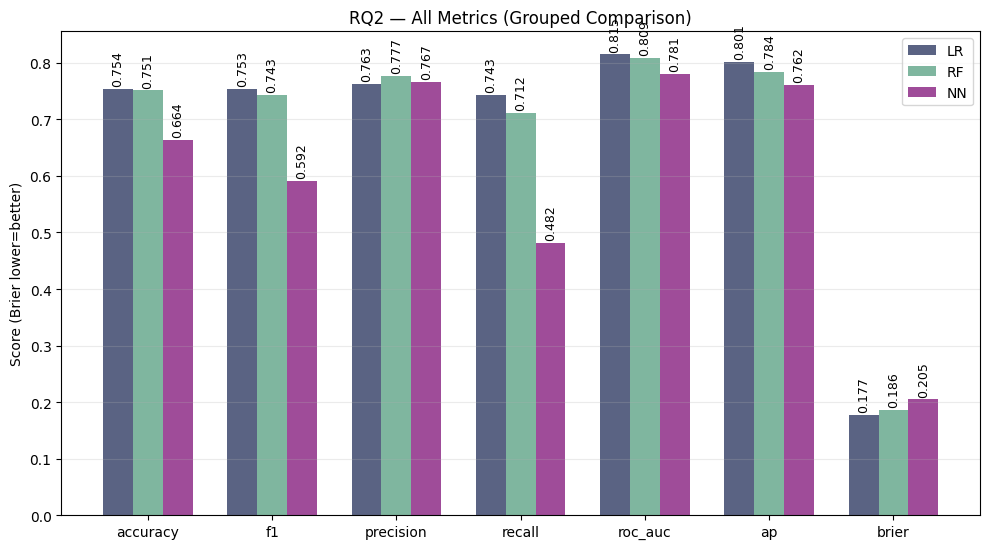

Saved grouped bars -> results/figures/rq2_all_metrics_grouped_bars.png


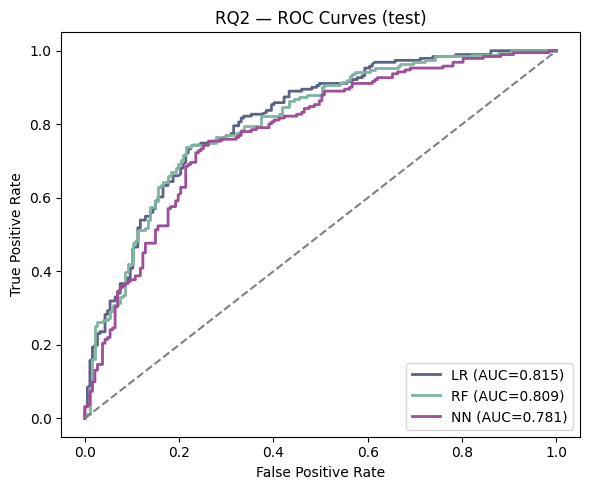

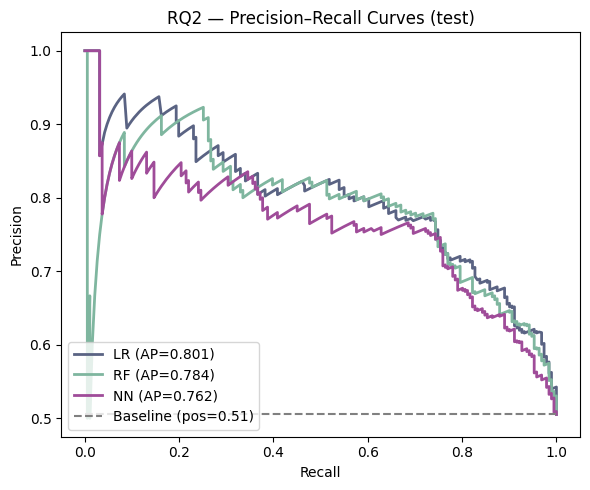

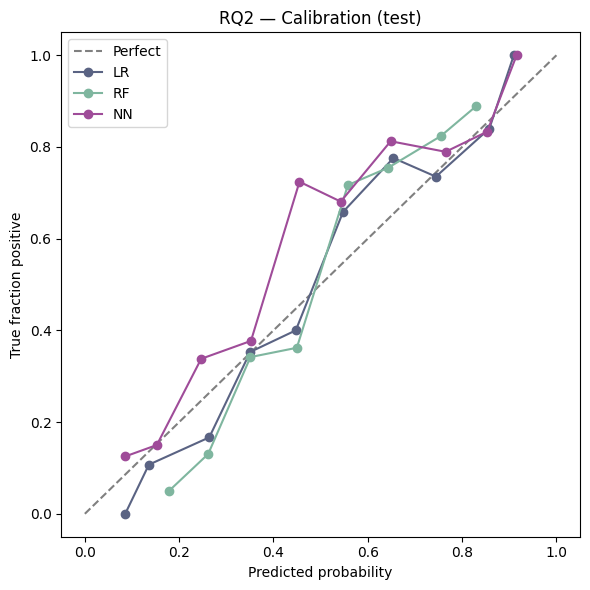

In [16]:

# RQ2 — Unified comparison figure cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve

# Build a comparison table
acc_lr = accuracy_score(y_test_rq2, y_pred_lr_rq2)
acc_rf = accuracy_score(y_test_rq2, y_pred_rf_rq2)
acc_nn = accuracy_score(y_test_rq2, y_pred_nn_rq2)


comp_rq2 = (
    pd.DataFrame({
        "LR": {
            "accuracy": acc_lr,
            "f1":        metrics_lr_rq2["f1"],
            "precision": metrics_lr_rq2["precision"],
            "recall":    metrics_lr_rq2["recall"],
            "roc_auc":   metrics_lr_rq2["roc_auc"],
            "ap":        metrics_lr_rq2["ap"],
            "brier":     metrics_lr_rq2["brier"],
        },
        "RF": {
            "accuracy": acc_rf,
            "f1":        metrics_rf_rq2["f1"],
            "precision": metrics_rf_rq2["precision"],
            "recall":    metrics_rf_rq2["recall"],
            "roc_auc":   metrics_rf_rq2["roc_auc"],
            "ap":        metrics_rf_rq2["ap"],
            "brier":     metrics_rf_rq2["brier"],
        },
        "NN": {
            "accuracy": acc_nn,
            "f1":        metrics_nn_rq2["f1"],
            "precision": metrics_nn_rq2["precision"],
            "recall":    metrics_nn_rq2["recall"],
            "roc_auc":   metrics_nn_rq2["roc_auc"],
            "ap":        metrics_nn_rq2["ap"],
            "brier":     metrics_nn_rq2["brier"],
        },
    }).T[["accuracy","f1","precision","recall","roc_auc","ap","brier"]]
)

print("\n=== RQ2 — Model comparison (thr=0.50) ===")
display(comp_rq2)


COLORS = {"LR": "#5A6383", "RF": "#7FB69F", "NN": "#9F4C99"}

# GROUPED BAR CHART
metric_order = ["accuracy","f1","precision","recall","roc_auc","ap","brier"]
x = np.arange(len(metric_order))
width = 0.24

plt.figure(figsize=(10, 5.6))
plt.bar(x - width, comp_rq2.loc["LR", metric_order].values, width, label="LR", color=COLORS["LR"])
plt.bar(x,          comp_rq2.loc["RF", metric_order].values, width, label="RF", color=COLORS["RF"])
plt.bar(x + width,  comp_rq2.loc["NN", metric_order].values, width, label="NN", color=COLORS["NN"])

plt.xticks(x, metric_order)
plt.ylabel("Score (Brier lower=better)")
plt.title("RQ2 — All Metrics (Grouped Comparison)")
plt.grid(axis="y", alpha=0.25)
plt.legend()



# Annotate bars with values
for bars in plt.gca().containers:
    plt.bar_label(bars, fmt="%.3f", padding=2, fontsize=9, rotation=90)

bars_path = DIRS["figures"] / "rq2_all_metrics_grouped_bars.png"
plt.tight_layout()
plt.savefig(bars_path, dpi=200)
plt.show()
print("Saved grouped bars ->", bars_path)

from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,5))
for name, y_score, color in [
    ("LR", y_prob_lr_rq2, COLORS["LR"]),
    ("RF", y_prob_rf_rq2, COLORS["RF"]),
    ("NN", y_prob_nn_rq2, COLORS["NN"]),
]:
    fpr, tpr, _ = roc_curve(y_test_rq2, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})", color=color, linewidth=2)

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RQ2 — ROC Curves (test)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Overlay Precision–Recall curves
plt.figure(figsize=(6,5))
for name, y_score, color in [
    ("LR", y_prob_lr_rq2, COLORS["LR"]),
    ("RF", y_prob_rf_rq2, COLORS["RF"]),
    ("NN", y_prob_nn_rq2, COLORS["NN"]),
]:
    precision, recall, _ = precision_recall_curve(y_test_rq2, y_score)
    ap = average_precision_score(y_test_rq2, y_score)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})", color=color, linewidth=2)



baseline = y_test_rq2.mean()
plt.hlines(baseline, 0, 1, colors="gray", linestyles="--", label=f"Baseline (pos={baseline:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("RQ2 — Precision–Recall Curves (test)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Overlay Calibration curves
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], "--", color="gray", label="Perfect")

for name, y_score, color in [
    ("LR", y_prob_lr_rq2, COLORS["LR"]),
    ("RF", y_prob_rf_rq2, COLORS["RF"]),
    ("NN", y_prob_nn_rq2, COLORS["NN"]),
]:
    prob_true, prob_pred = calibration_curve(y_test_rq2, y_score, n_bins=10, strategy="uniform")
    plt.plot(prob_pred, prob_true, marker="o", label=name, color=color)

plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("RQ2 — Calibration (test)")
plt.legend()
plt.tight_layout()
plt.show()

## Full vs Reduced Feature Set: Results  

This section compares the performance of all three models — **Logistic Regression (LR)**, **Random Forest (RF)**, and **Neural Network (NN)** — when trained and evaluated on the **full feature set** versus a **reduced subset of the top 15 features** (selected via aggregated permutation importance).  

### Evaluation Metrics  
- **Accuracy** – overall proportion of correct predictions  
- **F1 Score** – harmonic mean of precision and recall, balancing false positives/negatives  
- **Precision** – fraction of predicted “Treatment” cases that are correct  
- **Recall** – fraction of actual “Treatment” cases correctly identified  
- **ROC-AUC** – model’s ability to discriminate between classes across thresholds  
- **AP (Average Precision)** – area under the precision–recall curve, sensitive to imbalance  
- **Brier Score** – mean squared error of predicted probabilities (lower is better)  

### Results Tables  
The following two tables present the results for each model:  

- **Full Feature Set** – trained with all available predictors after preprocessing  
- **Reduced Feature Set (Top-15)** – trained only with the most important predictors  

This comparison highlights where dimensionality reduction preserves performance (e.g., discrimination via ROC-AUC, F1) and where trade-offs occur (e.g., precision–recall balance or calibration measured by Brier score).  


In [17]:
from sklearn.metrics import accuracy_score

#  FULL feature set results
acc_lr_full = accuracy_score(y_test, y_pred_lr)
acc_rf_full = accuracy_score(y_test, y_pred_rf)
acc_nn_full = accuracy_score(y_test, y_pred_nn)

comp_full = pd.DataFrame({
    "LR": {
        "accuracy": acc_lr_full,
        "f1": metrics_lr["f1"],
        "precision": metrics_lr["precision"],
        "recall": metrics_lr["recall"],
        "roc_auc": metrics_lr["roc_auc"],
        "ap": metrics_lr["ap"],
        "brier": metrics_lr["brier"],
    },
    "RF": {
        "accuracy": acc_rf_full,
        "f1": metrics_rf["f1"],
        "precision": metrics_rf["precision"],
        "recall": metrics_rf["recall"],
        "roc_auc": metrics_rf["roc_auc"],
        "ap": metrics_rf["ap"],
        "brier": metrics_rf["brier"],
    },
    "NN": {
        "accuracy": acc_nn_full,
        "f1": metrics_nn["f1"],
        "precision": metrics_nn["precision"],
        "recall": metrics_nn["recall"],
        "roc_auc": metrics_nn["roc_auc"],
        "ap": metrics_nn["ap"],
        "brier": metrics_nn["brier"],
    }
}).T

# REDUCED (15 feature) results
acc_lr_red = accuracy_score(y_test_rq2, y_pred_lr_rq2)
acc_rf_red = accuracy_score(y_test_rq2, y_pred_rf_rq2)
acc_nn_red = accuracy_score(y_test_rq2, y_pred_nn_rq2)

comp_reduced = pd.DataFrame({
    "LR": {
        "accuracy": acc_lr_red,
        "f1": metrics_lr_rq2["f1"],
        "precision": metrics_lr_rq2["precision"],
        "recall": metrics_lr_rq2["recall"],
        "roc_auc": metrics_lr_rq2["roc_auc"],
        "ap": metrics_lr_rq2["ap"],
        "brier": metrics_lr_rq2["brier"],
    },
    "RF": {
        "accuracy": acc_rf_red,
        "f1": metrics_rf_rq2["f1"],
        "precision": metrics_rf_rq2["precision"],
        "recall": metrics_rf_rq2["recall"],
        "roc_auc": metrics_rf_rq2["roc_auc"],
        "ap": metrics_rf_rq2["ap"],
        "brier": metrics_rf_rq2["brier"],
    },
    "NN": {
        "accuracy": acc_nn_red,
        "f1": metrics_nn_rq2["f1"],
        "precision": metrics_nn_rq2["precision"],
        "recall": metrics_nn_rq2["recall"],
        "roc_auc": metrics_nn_rq2["roc_auc"],
        "ap": metrics_nn_rq2["ap"],
        "brier": metrics_nn_rq2["brier"],
    }
}).T

print("=== Full features comparison table ===")
display(comp_full)

print("=== Reduced features comparison table ===")
display(comp_reduced)


=== Full features comparison table ===


,accuracy,f1,precision,recall,roc_auc,ap,brier
LR,0.740741,0.739362,0.751351,0.727749,0.819330,0.806943,0.173593
RF,0.759259,0.753388,0.780899,0.727749,0.815158,0.788334,0.186923
NN,0.711640,0.706199,0.727778,0.685864,0.803455,0.782436,0.182999


=== Reduced features comparison table ===


,accuracy,f1,precision,recall,roc_auc,ap,brier
LR,0.753968,0.753316,0.763441,0.743455,0.814934,0.801086,0.177211
RF,0.751323,0.743169,0.777143,0.712042,0.808663,0.784359,0.185701
NN,0.664021,0.591640,0.766667,0.481675,0.780735,0.761558,0.204975


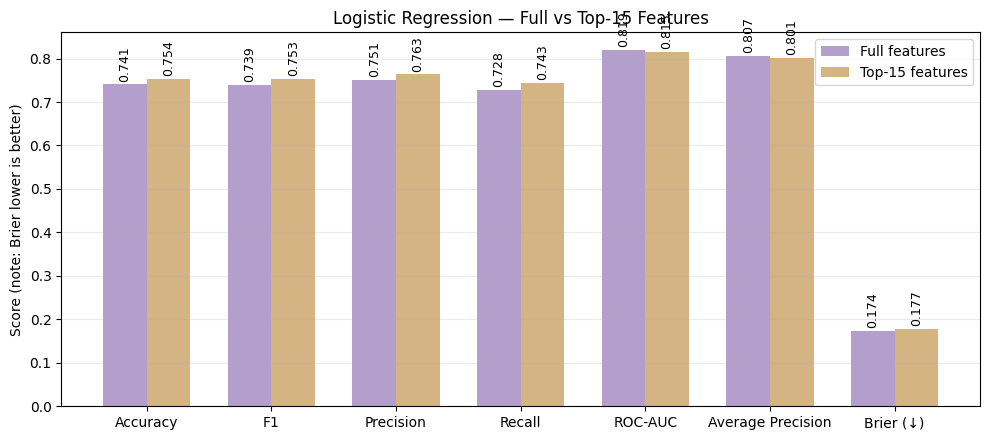

Saved -> results/figures/lr_full_vs_top15_grouped.png


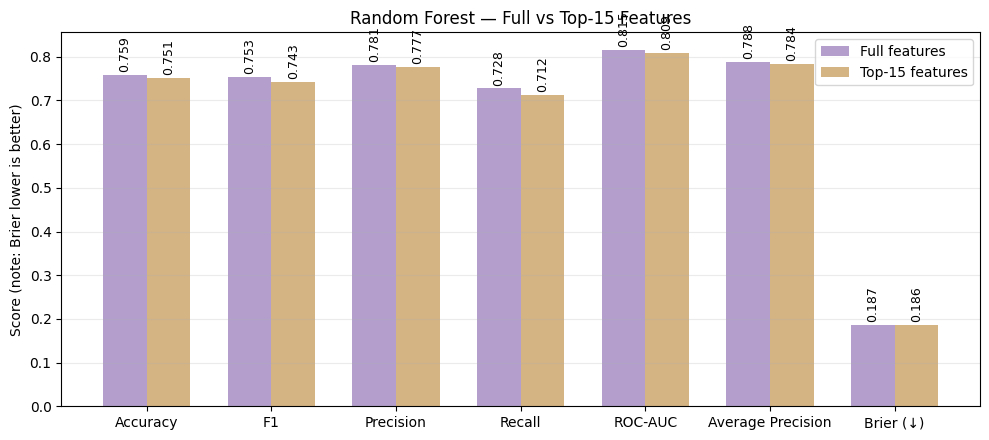

Saved -> results/figures/rf_full_vs_top15_grouped.png


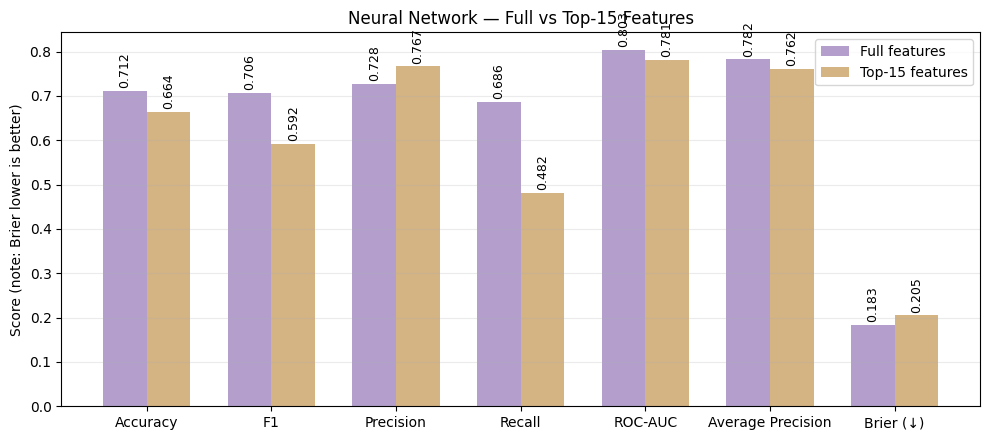

Saved -> results/figures/nn_full_vs_top15_grouped.png


In [18]:

# Per-model grouped bars: Full vs Top-15

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


for df_name, df in [("comp_full", comp_full), ("comp_reduced", comp_reduced)]:
    assert isinstance(df, pd.DataFrame), f"{df_name} must be a DataFrame."
    for col in ["accuracy","f1","precision","recall","roc_auc","ap","brier"]:
        assert col in df.columns, f"{df_name} is missing column '{col}'"
    for idx in ["LR","RF","NN"]:
        assert idx in df.index, f"{df_name} index must include '{idx}'"

#save
FIG_DIR = Path(DIRS["figures"]) if "DIRS" in globals() else Path("./figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


models        = ["LR", "RF", "NN"]
model_titles  = {"LR": "Logistic Regression", "RF": "Random Forest", "NN": "Neural Network"}
metrics_order = ["accuracy","f1","precision","recall","roc_auc","ap","brier"]
nice_names    = {
    "accuracy": "Accuracy",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
    "roc_auc": "ROC-AUC",
    "ap": "Average Precision",
    "brier": "Brier (↓)"
}


COLOR_FULL = "#B49FCC"
COLOR_RED  = "#D4B483"

def plot_full_vs_reduced_for_model(model_key):
    """Grouped bars for a single model comparing full vs top-15 features across metrics."""
    vals_full = comp_full.loc[model_key, metrics_order].values.astype(float)
    vals_red  = comp_reduced.loc[model_key, metrics_order].values.astype(float)

    x = np.arange(len(metrics_order))
    w = 0.35

    plt.figure(figsize=(10, 4.5))
    bars1 = plt.bar(x - w/2, vals_full, width=w, label="Full features", color=COLOR_FULL)
    bars2 = plt.bar(x + w/2, vals_red,  width=w, label="Top-15 features", color=COLOR_RED)

    plt.xticks(x, [nice_names[m] for m in metrics_order], rotation=0)
    plt.ylabel("Score (note: Brier lower is better)")
    plt.title(f"{model_titles.get(model_key, model_key)} — Full vs Top‑15 Features")
    plt.grid(axis="y", alpha=0.25)
    plt.legend()


    for bars in (bars1, bars2):
        plt.bar_label(bars, fmt="%.3f", padding=2, fontsize=9, rotation=90)

    out_path = FIG_DIR / f"{model_key.lower()}_full_vs_top15_grouped.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()
    print(f"Saved -> {out_path}")


for m in models:
    plot_full_vs_reduced_for_model(m)


## RQ3 — Error Analysis & Model Blind Spots  

**Research Question 3 (RQ3):**  
*Which types of individuals are most often misclassified by predictive models, and what does this reveal about model blind spots?*  

This section moves beyond overall model performance to examine **systematic errors**. Even if global metrics such as F1 or ROC-AUC appear strong, subgroup-level analysis can reveal where models consistently underperform — highlighting fairness, interpretability, and practical reliability concerns.  

### Methodology  

1. **Unified probability extraction**  
   - Models include Logistic Regression, Random Forest, and Neural Network pipelines (both RQ1 full-feature and RQ2 reduced-feature versions).  
   - A helper function ensures consistent probability outputs across `predict_proba`, `decision_function`, and Keras-based models.  

2. **Threshold tuning**  
   - Thresholds are chosen on training data for:  
     - **t_f1**: maximizing F1  
     - **t_rec@0.80**: achieving ≥ 0.80 recall while maximizing F1  
   - Models are then evaluated at both the default (0.50) and train-selected thresholds.  

3. **Error tagging**  
   - Each prediction is classified as **TP**, **TN**, **FP**, or **FN**, creating a row-level error annotation.  

4. **Subgroup metrics**  
   - Evaluation tables are produced for categorical subgroups such as:  
     - Demographics: `gender_cleaned`, `age_bucket`, `self_employed`  
     - Workplace: `no_employees_bucket`, `supervisor`, `coworkers`, `leave`  
     - Mental health variables: `work_interfere`, `benefits`, `anonymity`, `mental_health_consequence`  
   - Each subgroup report includes size, precision, recall, F1, ROC-AUC, AP, Brier score, and error composition rates (FP/FN/TN/TP).  

5. **Top misclassification segments**  
   - Subgroups with the **highest rates of false negatives (FN)** (missed treatment seekers) and **false positives (FP)** (over-predicted treatment seekers) are ranked, giving a prioritized view of blind spots.  

6. **Permutation importance**  
   - Additional PI analysis on misclassified subsets  highlights which features are most predictive of where the model fails.  



In [19]:

# RQ3 — Error Analysis & Model Blind Spots

import numpy as np
import pandas as pd
import warnings
from collections import OrderedDict
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve
)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline


def _rq3_get_probabilities(model, X):
    """
    Return positive-class probabilities for different model types:
    - sklearn Pipeline/Estimator with predict_proba
    - sklearn Estimator with decision_function (scaled to 0-1)
    - dict with {"model": keras_model, "preprocess_dense": transformer}
    """

    if isinstance(model, dict) and "model" in model:
        nn = model["model"]
        pre = model.get("preprocess_dense", None)
        if pre is not None:
            Xd = pre.transform(X)
            if hasattr(Xd, "toarray"):
                Xd = Xd.toarray()
        else:
            Xd = X.values if hasattr(X, "values") else X
        probs = nn.predict(Xd, verbose=0).ravel().astype(float)
        return probs


    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1].astype(float)


    if hasattr(model, "decision_function"):
        scores = model.decision_function(X).astype(float)
        smin, smax = scores.min(), scores.max()
        if smax > smin:
            return (scores - smin) / (smax - smin)
        else:
            return np.zeros_like(scores, dtype=float)

    raise ValueError("Model type not recognized for probability extraction.")

def _rq3_choose_threshold_from_probs(y_true, y_prob, target_recall=0.80):
    """
    Pick:
      - t_f1: threshold maximizing F1 on TRAIN
      - t_rec: among thresholds with recall >= target_recall, pick best F1
    Handles precision_recall_curve indexing safely.
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    P, R, T = precision_recall_curve(y_true, y_prob)
    if len(T) == 0:
        return 0.50, None
    P, R = P[:-1], R[:-1]
    f1 = (2 * P * R) / (P + R + 1e-12)
    i_best = int(np.nanargmax(f1))
    t_f1 = float(T[i_best])
    t_rec = None
    hi = np.where(R >= target_recall)[0]
    if hi.size > 0:
        i_hr = int(hi[np.argmax(f1[hi])])
        t_rec = float(T[i_hr])
    return t_f1, t_rec

def _rq3_err_tags(y_true, y_pred):
    """Return an array of 'TN','FP','FN','TP' per row."""
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    tags = np.empty_like(y_true, dtype=object)
    tags[(y_true == 0) & (y_pred == 0)] = "TN"
    tags[(y_true == 0) & (y_pred == 1)] = "FP"
    tags[(y_true == 1) & (y_pred == 0)] = "FN"
    tags[(y_true == 1) & (y_pred == 1)] = "TP"
    return tags

def _rq3_metrics_at(y_true, y_prob, thr=0.50):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "threshold": thr,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan,
        "ap": average_precision_score(y_true, y_prob),
        "brier": brier_score_loss(y_true, y_prob),
    }

def _rq3_subgroup_table(df_eval, group_col):
    """
    For a chosen group column, compute subgroup-level metrics and error composition.
    df_eval must include: y_true, y_prob, y_pred, err_type, and the group_col.
    Returns a tidy DataFrame sorted by subgroup size (desc).
    """
    rows = []
    for g, sub in df_eval.groupby(group_col, dropna=False):
        yt = sub["y_true"].values
        yp = sub["y_pred"].values
        yprob = sub["y_prob"].values
        n = len(sub)
        if n == 0:
            continue
        prec = precision_score(yt, yp, zero_division=0)
        rec = recall_score(yt, yp)
        f1 = f1_score(yt, yp)
        roc = roc_auc_score(yt, yprob) if len(np.unique(yt)) > 1 else np.nan
        ap  = average_precision_score(yt, yprob)
        brier = brier_score_loss(yt, yprob)
        fp = np.mean(sub["err_type"] == "FP")
        fn = np.mean(sub["err_type"] == "FN")
        tn = np.mean(sub["err_type"] == "TN")
        tp = np.mean(sub["err_type"] == "TP")
        rows.append({
            group_col: g,
            "n": n,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": roc,
            "ap": ap,
            "brier": brier,
            "rate_FP": fp,
            "rate_FN": fn,
            "rate_TN": tn,
            "rate_TP": tp
        })
    out = pd.DataFrame(rows).sort_values("n", ascending=False)
    return out


def _rq3_perm_importance_on_subset(model, X, y, subset_mask, n_repeats=20, random_state=42):
    """
    Permutation importance on a subset (e.g., only FNs).
    - If `model` is a Pipeline, this runs PI on the Pipeline with the ORIGINAL X columns.
      => Names will be Xs.columns (raw features), not one-hot outputs.
    """
    if isinstance(model, dict):
        warnings.warn("Skipping permutation importance for NN dict bundle.")
        return None
    if not hasattr(model, "predict"):
        warnings.warn("Model has no predict().")
        return None

    idx = np.where(subset_mask)[0]
    if len(idx) < 50:
        warnings.warn(f"Subset too small for stable PI (n={len(idx)}). Skipping.")
        return None

    Xs = X.iloc[idx]
    ys = y.iloc[idx] if hasattr(y, "iloc") else y[idx]

    result = permutation_importance(
        model, Xs, ys,
        n_repeats=n_repeats,
        scoring="f1",
        random_state=random_state,
        n_jobs=-1
    )

    names = list(Xs.columns)
    if len(names) != len(result.importances_mean):
        warnings.warn(
            f"Name/importance length mismatch ({len(names)} vs {len(result.importances_mean)}). "
            "Falling back to positional indices."
        )
        names = list(range(len(result.importances_mean)))

    pi_df = pd.DataFrame({
        "feature": names,
        "import_mean": result.importances_mean,
        "import_std": result.importances_std
    }).sort_values("import_mean", ascending=False)

    return pi_df


def _rq3_perm_importance_transformed_space(model, X, y, subset_mask, n_repeats=20, random_state=42):
    if isinstance(model, dict):
        warnings.warn("NN dict bundle not supported for transformed-space PI.")
        return None
    if not isinstance(model, Pipeline):
        warnings.warn("Model is not a Pipeline; use the raw-space PI function.")
        return None

    pre = model.named_steps.get("preprocess", None)
    clf = model.named_steps.get("clf", None)
    if pre is None or clf is None:
        warnings.warn("Pipeline must have 'preprocess' and 'clf' steps.")
        return None

    idx = np.where(subset_mask)[0]
    if len(idx) < 50:
        warnings.warn(f"Subset too small for stable PI (n={len(idx)}). Skipping.")
        return None

    Xs = X.iloc[idx]
    ys = y.iloc[idx] if hasattr(y, "iloc") else y[idx]

    Z = pre.transform(Xs)
    if hasattr(Z, "toarray"):
        Z = Z.toarray()

    try:
        names = pre.get_feature_names_out()
    except Exception:
        names = [f"z{i}" for i in range(Z.shape[1])]

    result = permutation_importance(
        clf, Z, ys,
        n_repeats=n_repeats,
        scoring="f1",
        random_state=random_state,
        n_jobs=-1
    )

    if len(names) != len(result.importances_mean):
        warnings.warn(
            f"Transformed name/importance length mismatch ({len(names)} vs {len(result.importances_mean)}). "
            "Falling back to positional indices."
        )
        names = list(range(len(result.importances_mean)))

    pi_df = pd.DataFrame({
        "feature": names,
        "import_mean": result.importances_mean,
        "import_std": result.importances_std
    }).sort_values("import_mean", ascending=False)

    return pi_df


_rq3_models = OrderedDict()

for label, varname in [
    ("RQ1_LR", "best_lr"),
    ("RQ1_RF", "best_rf"),
    ("RQ1_NN", "best_models"),
    ("RQ2_LR", "best_lr_rq2"),
    ("RQ2_RF", "best_rf_rq2"),
    ("RQ2_NN", "best_models_rq2"),
]:
    if varname in globals():
        obj = globals()[varname]
        if label.endswith("NN") and isinstance(obj, dict):

            if "NN" in obj:
                _rq3_models[label] = obj["NN"]
        else:
            _rq3_models[label] = obj

if len(_rq3_models) == 0:
    warnings.warn("RQ3: No trained models found in the environment. "
                  "Add your fitted models to _rq3_models manually.")
    _rq3_models["EXAMPLE"] = None


_rq3_data = None
if all(k in globals() for k in ["X_train", "y_train", "X_test", "y_test"]):
    _rq3_data = ("RQ1", globals()["X_train"], globals()["y_train"], globals()["X_test"], globals()["y_test"])
elif all(k in globals() for k in ["X_train_rq2", "y_train_rq2", "X_test_rq2", "y_test_rq2"]):
    _rq3_data = ("RQ2", globals()["X_train_rq2"], globals()["y_train_rq2"], globals()["X_test_rq2"], globals()["y_test_rq2"])
else:
    raise RuntimeError("RQ3: Could not find train/test split variables. "
                       "Expected RQ1 (X_train,y_train,X_test,y_test) or RQ2 (X_train_rq2,...) to exist.")

_rq3_split_name, _rq3_X_train, _rq3_y_train, _rq3_X_test, _rq3_y_test = _rq3_data
print(f"[RQ3] Using {_rq3_split_name} train/test split for error analysis.")



_rq3_scores = []
_rq3_preds = {}

for name, model in _rq3_models.items():
    if model is None:
        continue
    try:
        yprob_tr = _rq3_get_probabilities(model, _rq3_X_train)
        t_f1, t_rec = _rq3_choose_threshold_from_probs(_rq3_y_train.values, yprob_tr, target_recall=0.80)
    except Exception as e:
        t_f1, t_rec = 0.50, None
        warnings.warn(f"[{name}] Threshold selection failed on TRAIN; using 0.50. Reason: {e}")

    yprob_te = _rq3_get_probabilities(model, _rq3_X_test)


    _rq3_scores.append({"model": name, "thr_type": "default_0.50", **_rq3_metrics_at(_rq3_y_test, yprob_te, thr=0.50)})
    _rq3_scores.append({"model": name, "thr_type": "t_f1(train)", **_rq3_metrics_at(_rq3_y_test, yprob_te, thr=t_f1)})
    if t_rec is not None:
        _rq3_scores.append({"model": name, "thr_type": "t_rec(train)", **_rq3_metrics_at(_rq3_y_test, yprob_te, thr=t_rec)})


    ypred_te = (yprob_te >= (t_f1 if t_rec is None else t_f1)).astype(int)
    eval_df = pd.DataFrame({
        "y_true": _rq3_y_test.values,
        "y_prob": yprob_te,
        "y_pred": ypred_te,
    }, index=_rq3_y_test.index)
    eval_df["err_type"] = _rq3_err_tags(eval_df["y_true"], eval_df["y_pred"])
    _rq3_preds[name] = eval_df

_rq3_scores_df = pd.DataFrame(_rq3_scores)
display(_rq3_scores_df.sort_values(["model","thr_type"]))


_rq3_choice = None
for pref in ["RQ1_RF", "RQ2_RF", "RQ1_LR", "RQ2_LR", "RQ1_NN", "RQ2_NN"]:
    if pref in _rq3_preds:
        _rq3_choice = pref
        break
if _rq3_choice is None:
    _rq3_choice = list(_rq3_preds.keys())[0]

print(f"[RQ3] Deep-dive model: {_rq3_choice}")
_rq3_eval = _rq3_preds[_rq3_choice].copy()



_rq3_candidate_groups = [
    "gender_cleaned", "age_bucket", "no_employees_bucket",
    "remote_work", "benefits", "anonymity", "leave",
    "coworkers", "supervisor",
    "work_interfere",
    "mental_health_consequence", "phys_health_consequence",
    "tech_company", "self_employed", "family_history"
]
_rq3_groups = [c for c in _rq3_candidate_groups if c in _rq3_X_test.columns]

_rq3_group_tables = {}
for gc in _rq3_groups:
    tab = _rq3_eval.join(_rq3_X_test[gc]).pipe(_rq3_subgroup_table, group_col=gc)
    _rq3_group_tables[gc] = tab


for gc in _rq3_groups[:6]:
    print(f"\n=== Subgroup metrics by '{gc}' — model={_rq3_choice} ===")
    display(_rq3_group_tables[gc].head(20))



def _rq3_top_error_segments(eval_df, X, group_cols, err="FN", top=10):
    """
    Return top subgroups by error rate among the group (proportion of err within that subgroup),
    plus counts. err in {"FP","FN"}.
    """
    rows = []
    df0 = eval_df.join(X[group_cols], how="left")
    for gc in group_cols:
        for g, sub in df0.groupby(gc, dropna=False):
            n = len(sub)
            if n < 10:
                continue
            rate = np.mean(sub["err_type"] == err)
            cnt  = int((sub["err_type"] == err).sum())
            rows.append({"group": gc, "level": g, "n": n, f"{err}_count": cnt, f"{err}_rate": rate})
    out = pd.DataFrame(rows)
    if out.empty:
        return out
    return out.sort_values([f"{err}_rate", f"{err}_count"], ascending=False).head(top)

print("\n=== Top FN segments (who we miss) ===")
display(_rq3_top_error_segments(_rq3_eval, _rq3_X_test, _rq3_groups, err="FN", top=12))

print("\n=== Top FP segments (where we over-call) ===")
display(_rq3_top_error_segments(_rq3_eval, _rq3_X_test, _rq3_groups, err="FP", top=12))


if _rq3_choice in _rq3_models and not isinstance(_rq3_models[_rq3_choice], dict):
    print(f"\n[Optional] Permutation importance on FN subset for '{_rq3_choice}'")
    _rq3_fn_mask = (_rq3_eval["err_type"] == "FN").values
    _rq3_pi_fn = _rq3_perm_importance_on_subset(_rq3_models[_rq3_choice], _rq3_X_test, _rq3_y_test, _rq3_fn_mask)
    if _rq3_pi_fn is not None:
        display(_rq3_pi_fn.head(20))



print("\n[RQ3] Done. You now have:")
print(" - _rq3_scores_df  -> overall metrics at default and train-picked thresholds per model")
print(" - _rq3_eval       -> per-row eval (y_true, y_prob, y_pred, err_type) for the chosen model")
print(" - _rq3_group_tables[<col>] -> subgroup metrics/error tables for many columns")
print(" - Top FN/FP segment tables to see blind spots")
print(" - Optional permutation importance on misclassified subsets (if model is sklearn)")


[RQ3] Using RQ1 train/test split for error analysis.


,model,thr_type,threshold,precision,recall,f1,roc_auc,ap,brier
0,RQ1_LR,default_0.50,0.500000,0.751351,0.727749,0.739362,0.819330,0.806943,0.173593
1,RQ1_LR,t_f1(train),0.502252,0.750000,0.722513,0.736000,0.819330,0.806943,0.173593
2,RQ1_LR,t_rec(train),0.502252,0.750000,0.722513,0.736000,0.819330,0.806943,0.173593
3,RQ1_RF,default_0.50,0.500000,0.780899,0.727749,0.753388,0.815158,0.788334,0.186923
4,RQ1_RF,t_f1(train),0.407776,0.675105,0.837696,0.747664,0.815158,0.788334,0.186923
5,RQ1_RF,t_rec(train),0.407776,0.675105,0.837696,0.747664,0.815158,0.788334,0.186923
6,RQ2_LR,default_0.50,0.500000,0.763441,0.743455,0.753316,0.814934,0.801086,0.177211
7,RQ2_LR,t_f1(train),0.419156,0.714286,0.811518,0.759804,0.814934,0.801086,0.177211
8,RQ2_LR,t_rec(train),0.419156,0.714286,0.811518,0.759804,0.814934,0.801086,0.177211
9,RQ2_RF,default_0.50,0.500000,0.777143,0.712042,0.743169,0.808663,0.784359,0.185701


[RQ3] Deep-dive model: RQ1_RF


/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp


=== Subgroup metrics by 'gender_cleaned' — model=RQ1_RF ===


/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp

,gender_cleaned,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
1,male,287,0.647799,0.792308,0.712803,0.802499,0.736561,0.190825,0.195122,0.094077,0.351916,0.358885
0,female,83,0.714286,0.925926,0.806452,0.818646,0.865959,0.175992,0.240964,0.048193,0.108434,0.602410
2,other,8,0.875000,1.000000,0.933333,0.714286,0.961735,0.160331,0.125000,0.000000,0.000000,0.875000



=== Subgroup metrics by 'age_bucket' — model=RQ1_RF ===


,age_bucket,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
2,30s,161,0.650485,0.870130,0.744444,0.816636,0.796296,0.185860,0.223602,0.062112,0.298137,0.416149
1,20s,147,0.681818,0.810811,0.740741,0.844317,0.811723,0.180582,0.190476,0.095238,0.306122,0.408163
3,40s,54,0.675676,0.833333,0.746269,0.727778,0.759485,0.209863,0.222222,0.092593,0.222222,0.462963
4,50s,9,0.800000,0.800000,0.800000,0.950000,0.966667,0.165055,0.111111,0.111111,0.333333,0.444444
5,unknown,4,1.000000,1.000000,1.000000,1.000000,1.000000,0.148975,0.000000,0.000000,0.500000,0.500000
0,10s,3,1.000000,0.666667,0.800000,NaN,1.000000,0.257961,0.000000,0.333333,0.000000,0.666667



=== Subgroup metrics by 'no_employees_bucket' — model=RQ1_RF ===


,no_employees_bucket,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,1000+,99,0.560606,0.787234,0.654867,0.778642,0.723209,0.199797,0.292929,0.101010,0.232323,0.373737
5,6–25,89,0.704545,0.794872,0.746988,0.844615,0.792289,0.179945,0.146067,0.089888,0.415730,0.348315
3,26–100,77,0.750000,0.804878,0.776471,0.827236,0.825714,0.181014,0.142857,0.103896,0.324675,0.428571
1,100–500,51,0.702703,0.928571,0.800000,0.833851,0.852645,0.187827,0.215686,0.039216,0.235294,0.509804
2,1–5,45,0.812500,0.896552,0.852459,0.823276,0.867725,0.188308,0.133333,0.066667,0.222222,0.577778
4,500–1000,17,0.500000,1.000000,0.666667,0.942857,0.932540,0.168867,0.411765,0.000000,0.176471,0.411765



=== Subgroup metrics by 'remote_work' — model=RQ1_RF ===


,remote_work,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,no,278,0.652941,0.816176,0.725490,0.809548,0.781426,0.187787,0.21223,0.089928,0.298561,0.399281
1,yes,100,0.731343,0.890909,0.803279,0.827071,0.818504,0.184521,0.18000,0.060000,0.270000,0.490000



=== Subgroup metrics by 'benefits' — model=RQ1_RF ===


,benefits,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
2,yes,150,0.643411,0.965116,0.772093,0.831395,0.825615,0.181518,0.306667,0.020000,0.120000,0.553333
1,unknown,124,0.756098,0.563636,0.645833,0.845323,0.837568,0.189159,0.080645,0.193548,0.475806,0.250000
0,no,104,0.686567,0.920000,0.786325,0.824815,0.769832,0.192054,0.201923,0.038462,0.317308,0.442308



=== Subgroup metrics by 'anonymity' — model=RQ1_RF ===


,anonymity,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,Don't know,244,0.656000,0.738739,0.694915,0.803292,0.735133,0.189964,0.176230,0.118852,0.368852,0.336066
2,Yes,117,0.680000,0.985507,0.804734,0.801630,0.847298,0.185847,0.273504,0.008547,0.136752,0.581197
1,No,17,0.833333,0.909091,0.869565,0.954545,0.980519,0.150680,0.117647,0.058824,0.235294,0.588235



=== Top FN segments (who we miss) ===


/tmp/ipython-input-3650475234.py:359: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df0.groupby(gc, dropna=False):


,group,level,n,FN_count,FN_rate
14,benefits,unknown,124,24,0.193548
22,leave,Very difficult,20,3,0.150000
27,supervisor,no,112,16,0.142857
40,tech_company,no,73,10,0.136986
44,family_history,no,242,29,0.119835
16,anonymity,Don't know,244,29,0.118852
24,coworkers,No,74,8,0.108108
39,phys_health_consequence,Yes,19,2,0.105263
8,no_employees_bucket,26–100,77,8,0.103896
34,mental_health_consequence,Maybe,148,15,0.101351



=== Top FP segments (where we over-call) ===


/tmp/ipython-input-3650475234.py:359: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df0.groupby(gc, dropna=False):


,group,level,n,FP_count,FP_rate
9,no_employees_bucket,500–1000,17,7,0.411765
24,coworkers,No,74,23,0.310811
15,benefits,yes,150,46,0.306667
5,no_employees_bucket,1000+,99,29,0.292929
18,anonymity,Yes,117,32,0.273504
37,phys_health_consequence,Maybe,78,21,0.269231
36,mental_health_consequence,Yes,88,22,0.250000
43,self_employed,yes,44,11,0.250000
40,tech_company,no,73,18,0.246575
0,gender_cleaned,female,83,20,0.240964



[Optional] Permutation importance on FN subset for 'RQ1_RF'

[RQ3] Done. You now have:
 - _rq3_scores_df  -> overall metrics at default and train-picked thresholds per model
 - _rq3_eval       -> per-row eval (y_true, y_prob, y_pred, err_type) for the chosen model
 - _rq3_group_tables[<col>] -> subgroup metrics/error tables for many columns
 - Top FN/FP segment tables to see blind spots
 - Optional permutation importance on misclassified subsets (if model is sklearn)


/tmp/ipython-input-3650475234.py:156: UserWarning: Subset too small for stable PI (n=31). Skipping.
  warnings.warn(f"Subset too small for stable PI (n={len(idx)}). Skipping.")


In [20]:
# RQ3 — FN/FP subgroup tables


def format_top_errors(eval_df, X, groups, err="FN", top=6):
    """
    Return a clean table of top subgroups by error rate.
    err: "FN" (missed positives) or "FP" (over-called negatives)
    """
    rows = []
    df0 = eval_df.join(X[groups], how="left")
    for gc in groups:
        for g, sub in df0.groupby(gc, dropna=False):
            n = len(sub)
            if n < 20:
                continue
            rate = np.mean(sub["err_type"] == err)
            if rate <= 0:
                continue
            rows.append({
                "Group": f"{gc} = {g}",
                "%": round(rate * 100, 1),
                "n": n
            })
    out = pd.DataFrame(rows).sort_values("%", ascending=False).head(top)
    return out

# False Negatives:
fn_table = format_top_errors(_rq3_eval, _rq3_X_test, _rq3_groups, err="FN", top=6)
fn_table = fn_table.rename(columns={"%": "% Missed"})
print("\nFalse Negatives ")
display(fn_table[["Group","% Missed"]])

#  False Positives:
fp_table = format_top_errors(_rq3_eval, _rq3_X_test, _rq3_groups, err="FP", top=7)
fp_table = fp_table.rename(columns={"%": "% Overcalled"})
print("\n False Positives")
display(fp_table[["Group","% Overcalled"]])



False Negatives 


/tmp/ipython-input-285895666.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df0.groupby(gc, dropna=False):


,Group,% Missed
13,benefits = unknown,19.4
20,leave = Very difficult,15.0
25,supervisor = no,14.3
37,tech_company = no,13.7
41,family_history = no,12.0
15,anonymity = Don't know,11.9



 False Positives


/tmp/ipython-input-285895666.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df0.groupby(gc, dropna=False):


,Group,% Overcalled
22,coworkers = No,31.1
14,benefits = yes,30.7
5,no_employees_bucket = 1000+,29.3
16,anonymity = Yes,27.4
35,phys_health_consequence = Maybe,26.9
40,self_employed = yes,25.0
34,mental_health_consequence = Yes,25.0


In [21]:
# RQ3 — Subgroup FN/FP tables for ALL models


import numpy as np
import pandas as pd
import warnings


try:
    _rq3_get_probabilities
except NameError:
    from sklearn.metrics import precision_recall_curve
    def _rq3_get_probabilities(model, X):

        if isinstance(model, dict) and "model" in model:
            nn = model["model"]
            pre = model.get("preprocess_dense", None)
            if pre is not None:
                Z = pre.transform(X)
                if hasattr(Z, "toarray"): Z = Z.toarray()
            else:
                Z = X.values if hasattr(X, "values") else X
            return nn.predict(Z, verbose=0).ravel().astype(float)
        if hasattr(model, "predict_proba"):
            return model.predict_proba(X)[:, 1].astype(float)
        if hasattr(model, "decision_function"):
            s = model.decision_function(X).astype(float)
            smin, smax = s.min(), s.max()
            return (s - smin) / (smax - smin) if smax > smin else np.zeros_like(s, dtype=float)
        raise ValueError("Unsupported model type for probability extraction.")

    def _rq3_choose_threshold_from_probs(y_true, y_prob, target_recall=0.80):
        from sklearn.metrics import precision_recall_curve
        y_true = np.asarray(y_true).astype(int)
        y_prob = np.asarray(y_prob).astype(float)
        P, R, T = precision_recall_curve(y_true, y_prob)
        if len(T) == 0:
            return 0.50, None
        P, R = P[:-1], R[:-1]
        f1 = (2 * P * R) / (P + R + 1e-12)
        i_best = int(np.nanargmax(f1))
        t_f1 = float(T[i_best])
        t_rec = None
        hi = np.where(R >= target_recall)[0]
        if hi.size > 0:
            i_hr = int(hi[np.argmax(f1[hi])])
            t_rec = float(T[i_hr])
        return t_f1, t_rec

    def _rq3_err_tags(y_true, y_pred):
        y_true = np.asarray(y_true).astype(int)
        y_pred = np.asarray(y_pred).astype(int)
        tags = np.empty_like(y_true, dtype=object)
        tags[(y_true == 0) & (y_pred == 0)] = "TN"
        tags[(y_true == 0) & (y_pred == 1)] = "FP"
        tags[(y_true == 1) & (y_pred == 0)] = "FN"
        tags[(y_true == 1) & (y_pred == 1)] = "TP"
        return tags

    def _rq3_subgroup_table(df_eval, group_col):
        from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, brier_score_loss
        rows = []
        for g, sub in df_eval.groupby(group_col, dropna=False):
            yt = sub["y_true"].values
            yp = sub["y_pred"].values
            yprob = sub["y_prob"].values
            n = len(sub)
            if n == 0:
                continue
            prec = precision_score(yt, yp, zero_division=0)
            rec  = recall_score(yt, yp)
            f1   = f1_score(yt, yp)
            roc  = roc_auc_score(yt, yprob) if len(np.unique(yt)) > 1 else np.nan
            ap   = average_precision_score(yt, yprob)
            br   = brier_score_loss(yt, yprob)
            rows.append({
                group_col: g, "n": n, "precision": prec, "recall": rec,
                "f1": f1, "roc_auc": roc, "ap": ap, "brier": br,
                "rate_FP": np.mean(sub["err_type"] == "FP"),
                "rate_FN": np.mean(sub["err_type"] == "FN"),
                "rate_TN": np.mean(sub["err_type"] == "TN"),
                "rate_TP": np.mean(sub["err_type"] == "TP"),
            })
        return pd.DataFrame(rows).sort_values("n", ascending=False)

def _rq3_top_error_segments(eval_df, X, group_cols, err="FN", top=10, min_n=10):
    rows = []
    df0 = eval_df.join(X[group_cols], how="left")
    for gc in group_cols:
        for g, sub in df0.groupby(gc, dropna=False):
            n = len(sub)
            if n < min_n:
                continue
            cnt  = int((sub["err_type"] == err).sum())
            rate = np.mean(sub["err_type"] == err)
            rows.append({"group": gc, "level": g, "n": n, f"{err}_count": cnt, f"{err}_rate": rate})
    out = pd.DataFrame(rows)
    if out.empty: return out
    return out.sort_values([f"{err}_rate", f"{err}_count"], ascending=False).head(top)

#Find models & data split to use
if "_rq3_models" in globals() and len(_rq3_models) > 0:
    models_all = _rq3_models
else:
    models_all = {}
    for label, varname in [
        ("RQ1_LR", "best_lr"),
        ("RQ1_RF", "best_rf"),
        ("RQ1_NN", "best_models"),
        ("RQ2_LR", "best_lr_rq2"),
        ("RQ2_RF", "best_rf_rq2"),
        ("RQ2_NN", "best_models_rq2"),
    ]:
        if varname in globals():
            obj = globals()[varname]
            if label.endswith("NN") and isinstance(obj, dict) and "NN" in obj:
                models_all[label] = obj["NN"]
            else:
                models_all[label] = obj

# Pick split: prefer RQ1 if present else RQ2
if all(k in globals() for k in ["X_train", "y_train", "X_test", "y_test"]):
    split_name = "RQ1"
    Xtr, ytr, Xte, yte = X_train, y_train, X_test, y_test
elif all(k in globals() for k in ["X_train_rq2", "y_train_rq2", "X_test_rq2", "y_test_rq2"]):
    split_name = "RQ2"
    Xtr, ytr, Xte, yte = X_train_rq2, y_train_rq2, X_test_rq2, y_test_rq2
else:
    raise RuntimeError("Could not find train/test split. Need RQ1 or RQ2 split in the environment.")

print(f"[RQ3 ALL] Using {split_name} split for subgroup analysis across ALL models.")
print(f"Models considered: {list(models_all.keys())}")

# Groups to analyze
candidate_groups = [
    "gender_cleaned", "age_bucket", "no_employees_bucket",
    "remote_work", "benefits", "anonymity", "leave",
    "coworkers", "supervisor", "work_interfere",
    "mental_health_consequence", "phys_health_consequence",
    "tech_company", "self_employed", "family_history"
]
group_cols = [c for c in candidate_groups if c in Xte.columns]

# For EACH model: build eval, subgroup table,
per_model_eval = {}
per_model_group_tables = {}
per_model_topFN = []
per_model_topFP = []

for name, model in models_all.items():
    try:
        yprob_tr = _rq3_get_probabilities(model, Xtr)
        t_f1, t_rec = _rq3_choose_threshold_from_probs(ytr.values, yprob_tr, target_recall=0.80)
    except Exception as e:
        warnings.warn(f"[{name}] Threshold selection on TRAIN failed, using 0.50. Reason: {e}")
        t_f1, t_rec = 0.50, None

    # TEST probabilities and predictions at t_f1
    yprob_te = _rq3_get_probabilities(model, Xte)
    thr = t_f1 if t_f1 is not None else 0.50
    ypred_te = (yprob_te >= thr).astype(int)

    eval_df = pd.DataFrame({"y_true": yte.values, "y_prob": yprob_te, "y_pred": ypred_te}, index=yte.index)
    eval_df["err_type"] = _rq3_err_tags(eval_df["y_true"], eval_df["y_pred"])
    per_model_eval[name] = eval_df

    # subgroup table
    sub_tables = {}
    for gc in group_cols:
        tab = eval_df.join(Xte[gc]).pipe(_rq3_subgroup_table, group_col=gc)
        sub_tables[gc] = tab
    per_model_group_tables[name] = sub_tables

    # top FN / top FP
    top_fn = _rq3_top_error_segments(eval_df, Xte, group_cols, err="FN", top=12, min_n=10)
    top_fp = _rq3_top_error_segments(eval_df, Xte, group_cols, err="FP", top=12, min_n=10)
    if not top_fn.empty:
        top_fn.insert(0, "model", name)
        per_model_topFN.append(top_fn)
    if not top_fp.empty:
        top_fp.insert(0, "model", name)
        per_model_topFP.append(top_fp)

topFN_all = pd.concat(per_model_topFN, ignore_index=True) if per_model_topFN else pd.DataFrame()
topFP_all = pd.concat(per_model_topFP, ignore_index=True) if per_model_topFP else pd.DataFrame()

print("\n=== Top FN segments per model (who we miss) ===")
display(topFN_all)

print("\n=== Top FP segments per model (where we over-call) ===")
display(topFP_all)

for key_col in ["benefits", "leave", "no_employees_bucket"]:
    if key_col not in group_cols:
        continue
    print(f"\n=== Subgroup metrics by '{key_col}' — all models ===")
    for name in models_all.keys():
        if key_col in per_model_group_tables[name]:
            print(f"\n[{name}]")
            display(per_model_group_tables[name][key_col].head(20))

from pathlib import Path
try:
    out_dir = Path(DIRS["tables"])
except:
    out_dir = Path("./results/tables")
out_dir.mkdir(parents=True, exist_ok=True)

if not topFN_all.empty:
    topFN_all.to_csv(out_dir / "rq3_top_FN_all_models.csv", index=False)
if not topFP_all.empty:
    topFP_all.to_csv(out_dir / "rq3_top_FP_all_models.csv", index=False)
print(f"\nSaved merged tables to: {out_dir}")


[RQ3 ALL] Using RQ1 split for subgroup analysis across ALL models.
Models considered: ['RQ1_LR', 'RQ1_RF', 'RQ2_LR', 'RQ2_RF']


/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp


=== Top FN segments per model (who we miss) ===


/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-3650475234.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df_eval.groupby(group_col, dropna=False):
/tmp/ipython-input-1548239715.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in df0.groupby(gc, dropna=False):
/tmp/ipython-inp

,model,group,level,n,FN_count,FN_rate
0,RQ1_LR,leave,Very difficult,20,5,0.250000
1,RQ1_LR,benefits,unknown,124,29,0.233871
2,RQ1_LR,leave,Very easy,60,14,0.233333
3,RQ1_LR,supervisor,no,112,23,0.205357
4,RQ1_LR,self_employed,yes,44,9,0.204545
5,RQ1_LR,leave,Somewhat difficult,35,7,0.200000
6,RQ1_LR,family_history,no,242,47,0.194215
7,RQ1_LR,no_employees_bucket,6–25,89,17,0.191011
8,RQ1_LR,work_interfere,sometimes,175,32,0.182857
9,RQ1_LR,mental_health_consequence,No,142,25,0.176056



=== Top FP segments per model (where we over-call) ===


,model,group,level,n,FP_count,FP_rate
0,RQ1_LR,benefits,yes,150,31,0.206667
1,RQ1_LR,no_employees_bucket,1000+,99,20,0.202020
2,RQ1_LR,phys_health_consequence,Maybe,78,14,0.179487
3,RQ1_LR,no_employees_bucket,500–1000,17,3,0.176471
4,RQ1_LR,anonymity,Yes,117,20,0.170940
5,RQ1_LR,supervisor,some of them,124,21,0.169355
6,RQ1_LR,age_bucket,40s,54,9,0.166667
7,RQ1_LR,work_interfere,sometimes,175,29,0.165714
8,RQ1_LR,self_employed,yes,44,7,0.159091
9,RQ1_LR,family_history,yes,136,21,0.154412



=== Subgroup metrics by 'benefits' — all models ===

[RQ1_LR]


,benefits,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
2,yes,150,0.718182,0.918605,0.806122,0.859557,0.864625,0.159425,0.206667,0.046667,0.220000,0.526667
1,unknown,124,0.962963,0.472727,0.634146,0.823188,0.815926,0.183185,0.008065,0.233871,0.548387,0.209677
0,no,104,0.702128,0.660000,0.680412,0.800741,0.754838,0.182591,0.134615,0.163462,0.384615,0.317308



[RQ1_RF]


,benefits,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
2,yes,150,0.643411,0.965116,0.772093,0.831395,0.825615,0.181518,0.306667,0.020000,0.120000,0.553333
1,unknown,124,0.756098,0.563636,0.645833,0.845323,0.837568,0.189159,0.080645,0.193548,0.475806,0.250000
0,no,104,0.686567,0.920000,0.786325,0.824815,0.769832,0.192054,0.201923,0.038462,0.317308,0.442308



[RQ2_LR]


,benefits,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
2,yes,150,0.680328,0.965116,0.798077,0.850018,0.866263,0.165115,0.260000,0.020000,0.166667,0.553333
1,unknown,124,0.820513,0.581818,0.680851,0.827536,0.818677,0.180732,0.056452,0.185484,0.500000,0.258065
0,no,104,0.714286,0.800000,0.754717,0.786667,0.717996,0.190460,0.153846,0.096154,0.365385,0.384615



[RQ2_RF]


,benefits,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
2,yes,150,0.646154,0.976744,0.777778,0.829942,0.824138,0.177899,0.306667,0.013333,0.120000,0.560000
1,unknown,124,0.789474,0.545455,0.645161,0.840843,0.834715,0.187973,0.064516,0.201613,0.491935,0.241935
0,no,104,0.661538,0.860000,0.747826,0.809259,0.766000,0.194245,0.211538,0.067308,0.307692,0.413462



=== Subgroup metrics by 'leave' — all models ===

[RQ1_LR]


,leave,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,Don't know,183,0.678571,0.730769,0.703704,0.802930,0.755200,0.179560,0.147541,0.114754,0.426230,0.311475
2,Somewhat easy,80,0.731707,0.833333,0.779221,0.887626,0.859609,0.142362,0.137500,0.075000,0.412500,0.375000
4,Very easy,60,0.814815,0.611111,0.698413,0.814815,0.876797,0.187974,0.083333,0.233333,0.316667,0.366667
1,Somewhat difficult,35,0.857143,0.720000,0.782609,0.768000,0.839190,0.187139,0.085714,0.200000,0.200000,0.514286
3,Very difficult,20,1.000000,0.687500,0.814815,0.937500,0.984983,0.177075,0.000000,0.250000,0.200000,0.550000



[RQ1_RF]


,leave,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,Don't know,183,0.588235,0.769231,0.666667,0.798901,0.726731,0.189321,0.229508,0.098361,0.344262,0.327869
2,Somewhat easy,80,0.641509,0.944444,0.764045,0.863005,0.822258,0.173486,0.237500,0.025000,0.312500,0.425000
4,Very easy,60,0.769231,0.833333,0.800000,0.809028,0.874214,0.192001,0.150000,0.100000,0.250000,0.500000
1,Somewhat difficult,35,0.851852,0.920000,0.884615,0.820000,0.854648,0.188687,0.114286,0.057143,0.171429,0.657143
3,Very difficult,20,0.812500,0.812500,0.812500,0.765625,0.946051,0.200408,0.150000,0.150000,0.050000,0.650000



[RQ2_LR]


,leave,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,Don't know,183,0.632653,0.794872,0.704545,0.807082,0.754103,0.179223,0.196721,0.087432,0.377049,0.338798
2,Somewhat easy,80,0.680851,0.888889,0.771084,0.874053,0.845252,0.154010,0.187500,0.050000,0.362500,0.400000
4,Very easy,60,0.783784,0.805556,0.794521,0.797454,0.850669,0.185356,0.133333,0.116667,0.266667,0.483333
1,Somewhat difficult,35,0.863636,0.760000,0.808511,0.744000,0.822792,0.201281,0.085714,0.171429,0.200000,0.542857
3,Very difficult,20,1.000000,0.812500,0.896552,1.000000,1.000000,0.185055,0.000000,0.150000,0.200000,0.650000



[RQ2_RF]


,leave,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,Don't know,183,0.600000,0.769231,0.674157,0.794505,0.724217,0.186977,0.218579,0.098361,0.355191,0.327869
2,Somewhat easy,80,0.641509,0.944444,0.764045,0.869949,0.834922,0.168442,0.237500,0.025000,0.312500,0.425000
4,Very easy,60,0.743590,0.805556,0.773333,0.785880,0.856122,0.196288,0.166667,0.116667,0.233333,0.483333
1,Somewhat difficult,35,0.840000,0.840000,0.840000,0.808000,0.849841,0.189243,0.114286,0.114286,0.171429,0.600000
3,Very difficult,20,0.812500,0.812500,0.812500,0.718750,0.936234,0.205095,0.150000,0.150000,0.050000,0.650000



=== Subgroup metrics by 'no_employees_bucket' — all models ===

[RQ1_LR]


,no_employees_bucket,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,1000+,99,0.655172,0.808511,0.723810,0.790098,0.748405,0.192170,0.202020,0.090909,0.323232,0.383838
5,6–25,89,0.733333,0.564103,0.637681,0.823590,0.783238,0.170485,0.089888,0.191011,0.471910,0.247191
3,26–100,77,0.800000,0.682927,0.736842,0.834688,0.846029,0.166988,0.090909,0.168831,0.376623,0.363636
1,100–500,51,0.807692,0.750000,0.777778,0.818323,0.841484,0.177782,0.098039,0.137255,0.352941,0.411765
2,1–5,45,0.880000,0.758621,0.814815,0.842672,0.884843,0.160375,0.066667,0.155556,0.288889,0.488889
4,500–1000,17,0.700000,1.000000,0.823529,0.942857,0.936735,0.134021,0.176471,0.000000,0.411765,0.411765



[RQ1_RF]


,no_employees_bucket,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,1000+,99,0.560606,0.787234,0.654867,0.778642,0.723209,0.199797,0.292929,0.101010,0.232323,0.373737
5,6–25,89,0.704545,0.794872,0.746988,0.844615,0.792289,0.179945,0.146067,0.089888,0.415730,0.348315
3,26–100,77,0.750000,0.804878,0.776471,0.827236,0.825714,0.181014,0.142857,0.103896,0.324675,0.428571
1,100–500,51,0.702703,0.928571,0.800000,0.833851,0.852645,0.187827,0.215686,0.039216,0.235294,0.509804
2,1–5,45,0.812500,0.896552,0.852459,0.823276,0.867725,0.188308,0.133333,0.066667,0.222222,0.577778
4,500–1000,17,0.500000,1.000000,0.666667,0.942857,0.932540,0.168867,0.411765,0.000000,0.176471,0.411765



[RQ2_LR]


,no_employees_bucket,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,1000+,99,0.612903,0.808511,0.697248,0.783552,0.764303,0.193279,0.242424,0.090909,0.282828,0.383838
5,6–25,89,0.720930,0.794872,0.756098,0.840000,0.775747,0.167904,0.134831,0.089888,0.426966,0.348315
3,26–100,77,0.794872,0.756098,0.775000,0.846545,0.853185,0.164462,0.103896,0.129870,0.363636,0.402597
1,100–500,51,0.727273,0.857143,0.786885,0.804348,0.814798,0.184324,0.176471,0.078431,0.274510,0.470588
2,1–5,45,0.800000,0.827586,0.813559,0.801724,0.861437,0.184082,0.133333,0.111111,0.222222,0.533333
4,500–1000,17,0.700000,1.000000,0.823529,0.928571,0.908730,0.150589,0.176471,0.000000,0.411765,0.411765



[RQ2_RF]


,no_employees_bucket,n,precision,recall,f1,roc_auc,ap,brier,rate_FP,rate_FN,rate_TN,rate_TP
0,1000+,99,0.558824,0.808511,0.660870,0.769640,0.717502,0.200310,0.303030,0.090909,0.222222,0.383838
5,6–25,89,0.688889,0.794872,0.738095,0.838974,0.784938,0.178958,0.157303,0.089888,0.404494,0.348315
3,26–100,77,0.756098,0.756098,0.756098,0.827913,0.829455,0.178825,0.129870,0.129870,0.337662,0.402597
1,100–500,51,0.694444,0.892857,0.781250,0.840062,0.850231,0.181901,0.215686,0.058824,0.235294,0.490196
2,1–5,45,0.833333,0.862069,0.847458,0.818966,0.875683,0.189887,0.111111,0.088889,0.244444,0.555556
4,500–1000,17,0.538462,1.000000,0.700000,0.942857,0.932540,0.167388,0.352941,0.000000,0.235294,0.411765



Saved merged tables to: results/tables
